# KMMD metrics computation (R kernel)

## Utils

In [2]:
# install.packages("OpenImageR")
# install.packages("kernlab")
# install.packages("repr")
install.packages("BiocManager")
BiocManager::install("EBImage")

Installing package into 'C:/Users/peter/Documents/R/win-library/4.0'
(as 'lib' is unspecified)



package 'BiocManager' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\peter\AppData\Local\Temp\RtmpOcaAQU\downloaded_packages


'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.12 (BiocManager 1.30.12), R 4.0.5 (2021-03-31)

Installing package(s) 'BiocVersion', 'EBImage'

also installing the dependencies 'bitops', 'BiocGenerics', 'abind', 'locfit', 'fftwtools', 'RCurl'




package 'bitops' successfully unpacked and MD5 sums checked
package 'BiocGenerics' successfully unpacked and MD5 sums checked
package 'abind' successfully unpacked and MD5 sums checked
package 'locfit' successfully unpacked and MD5 sums checked
package 'fftwtools' successfully unpacked and MD5 sums checked
package 'RCurl' successfully unpacked and MD5 sums checked
package 'BiocVersion' successfully unpacked and MD5 sums checked
package 'EBImage' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\peter\AppData\Local\Temp\RtmpOcaAQU\downloaded_packages


Installation paths not writeable, unable to update packages
  path: C:/Program Files/R/R-4.0.5/library
  packages:
    cluster, mgcv

Old packages: 'callr', 'DT', 'haven', 'highr', 'knitr', 'parsedate',
  'RcppArmadillo', 'tibble', 'tidyverse', 'withr'



In [3]:
library(OpenImageR)
library(kernlab)
library(tidyverse)
library(ggplot2)
library(EBImage)


Attaching package: 'EBImage'


The following object is masked from 'package:purrr':

    transpose


The following objects are masked from 'package:OpenImageR':

    readImage, writeImage




## Computation of KMMD

In [4]:
compute_kmmd <- function(input_loc, recon_loc) {
    inputs = list.files(input_loc)
    recons = list.files(recon_loc)
    H0.reject = c()
    low_order_mmd_stats = c()
    high_order_mmd_stats = c()
    
    for (i in 1:length(inputs)) {
        input_img = readImage(paste(input_loc, "/", inputs[i], sep=""))
        recon_img = readImage(paste(recon_loc, "/", recons[i], sep=""))

        input_img = rgb_2gray(input_img)
        recon_img = rgb_2gray(recon_img)
        
        w_input = dim(input_img)[1]
        h_input = dim(input_img)[2]
        w_recon = dim(recon_img)[1]
        h_recon = dim(recon_img)[2]
        if ((w_input != w_recon) || (h_input != h_recon)) {
            recon_img = resize(recon_img, w_input, h_input)
        }
        
        result = kmmd(input_img, recon_img)
        H0.reject = append(H0.reject, result@H0)
        low_order_mmd_stats = append(low_order_mmd_stats, result@mmdstats[1])
        high_order_mmd_stats = append(high_order_mmd_stats, result@mmdstats[2])
    }
    
    result <- list("H0.reject" = H0.reject, "low_order_mmd_stats" = low_order_mmd_stats, "high_order_mmd_stats" = high_order_mmd_stats)
    return(result)
}

## Result of Flowers dataset for BigbiGAN

In [56]:
result = compute_kmmd("./bigbigan_flower_results/inputs", "./bigbigan_flower_results/recons")

Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (

In [57]:
H0.reject = result$H0.reject
df_H0.reject = as.data.frame(H0.reject) %>% group_by(H0.reject) %>% count() %>% rename("inference_count"=n)
low_order_mmd_stats = result$low_order_mmd_stats
df_low_order_mmd_stats = as.data.frame(low_order_mmd_stats)
high_order_mmd_stats = result$high_order_mmd_stats
df_high_order_mmd_stats = as.data.frame(high_order_mmd_stats)

### Hypothesis test result

$H_0$: two images have the same distribution.

$H_a$: two images do not have the same distribution.

Reference: http://www.gatsby.ucl.ac.uk/~gretton/mmd/mmd.htm

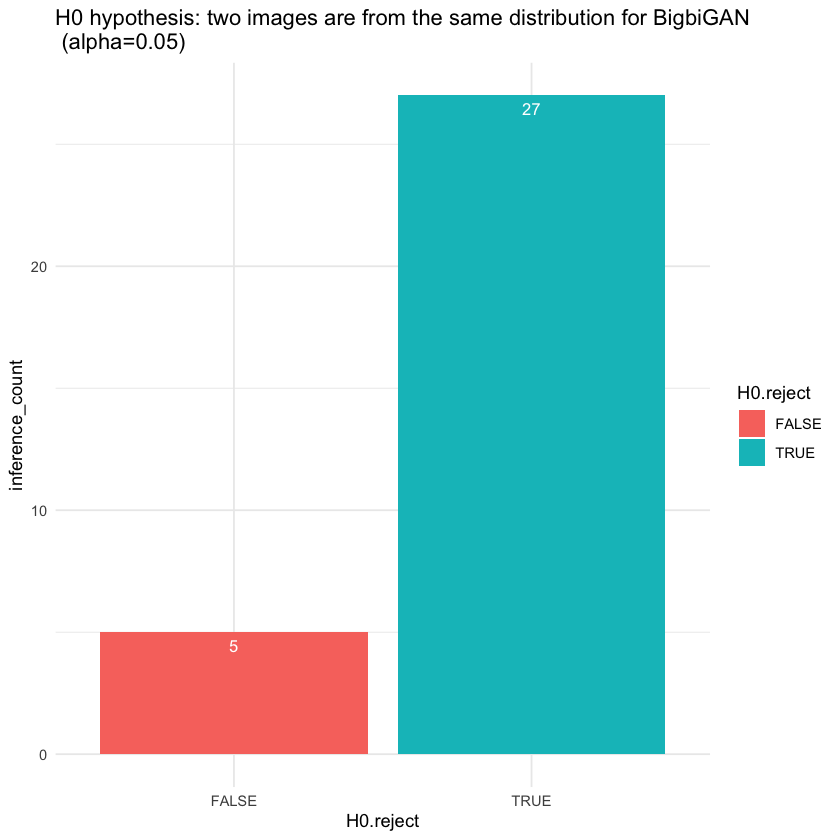

In [58]:
ggplot(data=df_H0.reject, aes(x=H0.reject, y=inference_count, fill=H0.reject)) +
  labs(title="H0 hypothesis: two images are from the same distribution for BigbiGAN\n (alpha=0.05)") +
  geom_bar(stat="identity")+
  geom_text(aes(label=inference_count), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

### MMD statistics
1. Density distribution for 1st order MMD statistics
2. Density distribution for 3rd order MMD statistics
3. Mean and other statistics for 1st order MMD statistics
4. Mean and other statistics for 3rd order MMD statistics

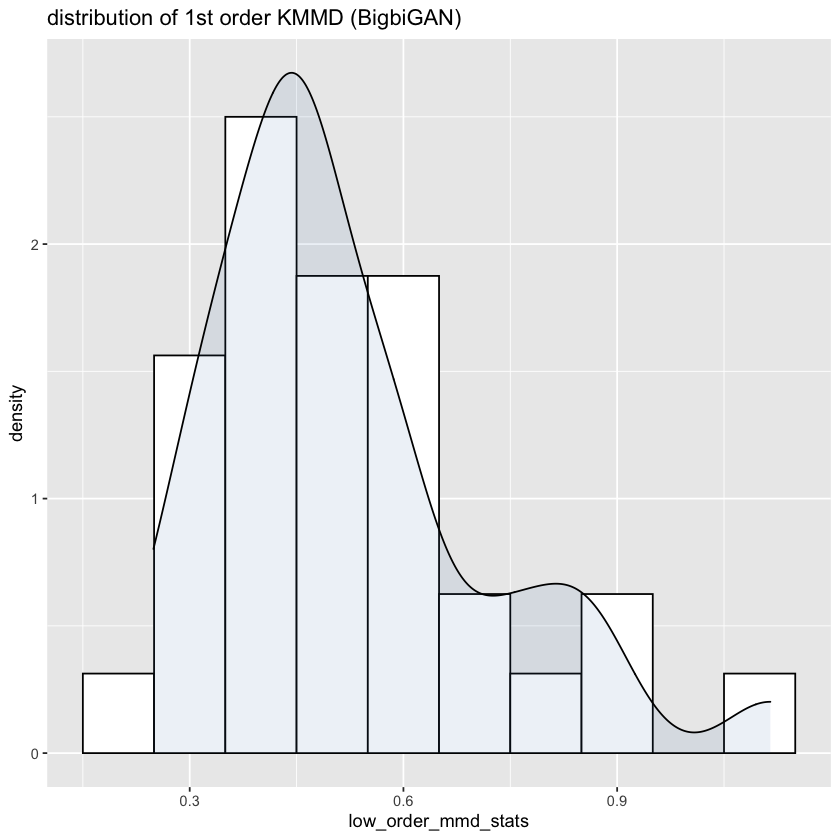

In [59]:
ggplot(df_low_order_mmd_stats, aes(x=low_order_mmd_stats)) +
    labs(title="distribution of 1st order KMMD (BigbiGAN)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="steelblue")  # Overlay with transparent density plot

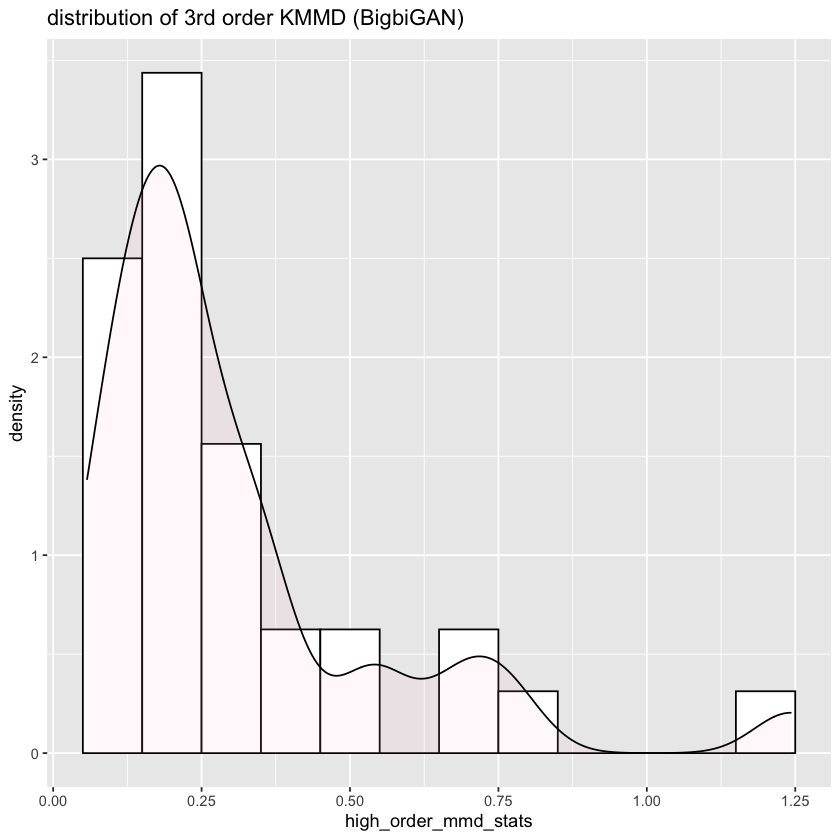

In [60]:
ggplot(df_high_order_mmd_stats, aes(x=high_order_mmd_stats)) +
    labs(title="distribution of 3rd order KMMD (BigbiGAN)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="pink")  # Overlay with transparent density plot

In [113]:
summary(df_low_order_mmd_stats)

 high_order_mmd_stats
 Min.   :0.06683     
 1st Qu.:0.12282     
 Median :0.17194     
 Mean   :0.23591     
 3rd Qu.:0.32188     
 Max.   :0.79631     

In [114]:
summary(df_high_order_mmd_stats)

 high_order_mmd_stats
 Min.   :0.06683     
 1st Qu.:0.12282     
 Median :0.17194     
 Mean   :0.23591     
 3rd Qu.:0.32188     
 Max.   :0.79631     

## Result of Flowers dataset for SNGan (iteration 500)

In [3]:
result2 = compute_kmmd("./sngan_flower_results/input", "./sngan_flower_results/iter_500")

Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (

In [4]:
H0.reject2 = result2$H0.reject
df_H0.reject2 = as.data.frame(H0.reject2) %>% group_by(H0.reject2) %>% count() %>% rename("inference_count"=n)
low_order_mmd_stats2 = result2$low_order_mmd_stats
df_low_order_mmd_stats2 = as.data.frame(low_order_mmd_stats2)
high_order_mmd_stats2 = result2$high_order_mmd_stats
df_high_order_mmd_stats2 = as.data.frame(high_order_mmd_stats2)

### Hypothesis test result 

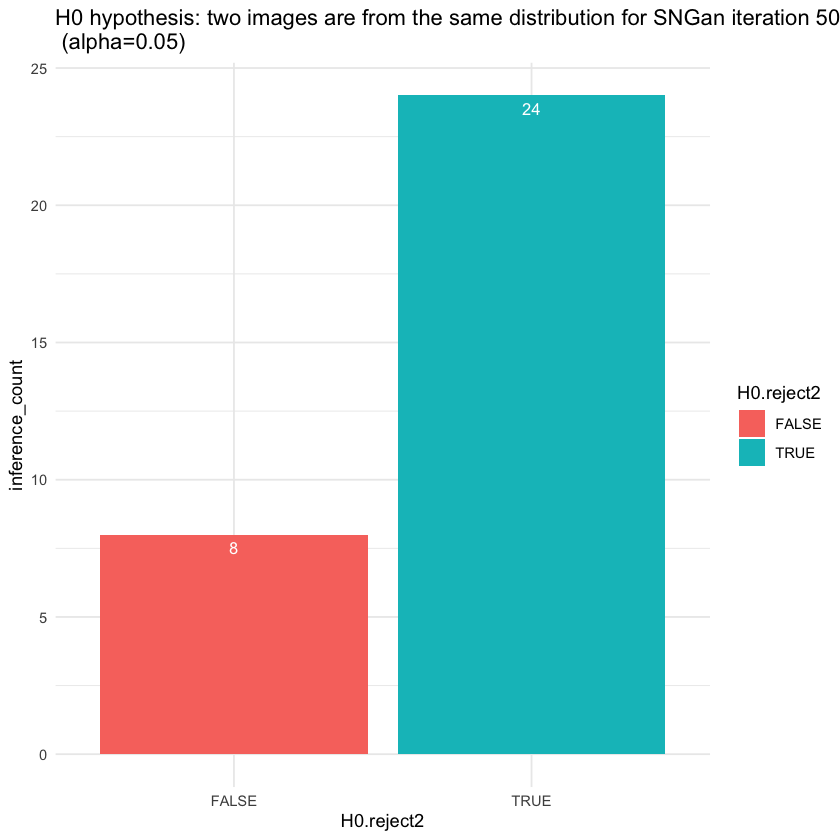

In [5]:
ggplot(data=df_H0.reject2, aes(x=H0.reject2, y=inference_count, fill=H0.reject2)) +
  labs(title="H0 hypothesis: two images are from the same distribution for SNGan iteration 500\n (alpha=0.05)") +
  geom_bar(stat="identity")+
  geom_text(aes(label=inference_count), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

### MMD statistics

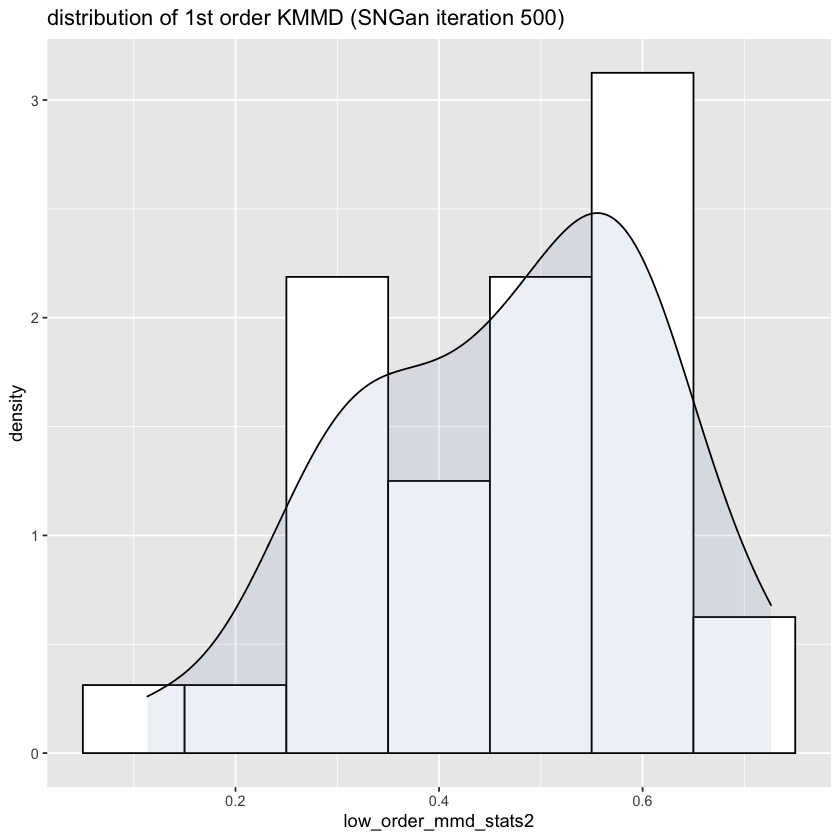

In [6]:
ggplot(df_low_order_mmd_stats2, aes(x=low_order_mmd_stats2)) +
    labs(title="distribution of 1st order KMMD (SNGan iteration 500)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="steelblue")  # Overlay with transparent density plot

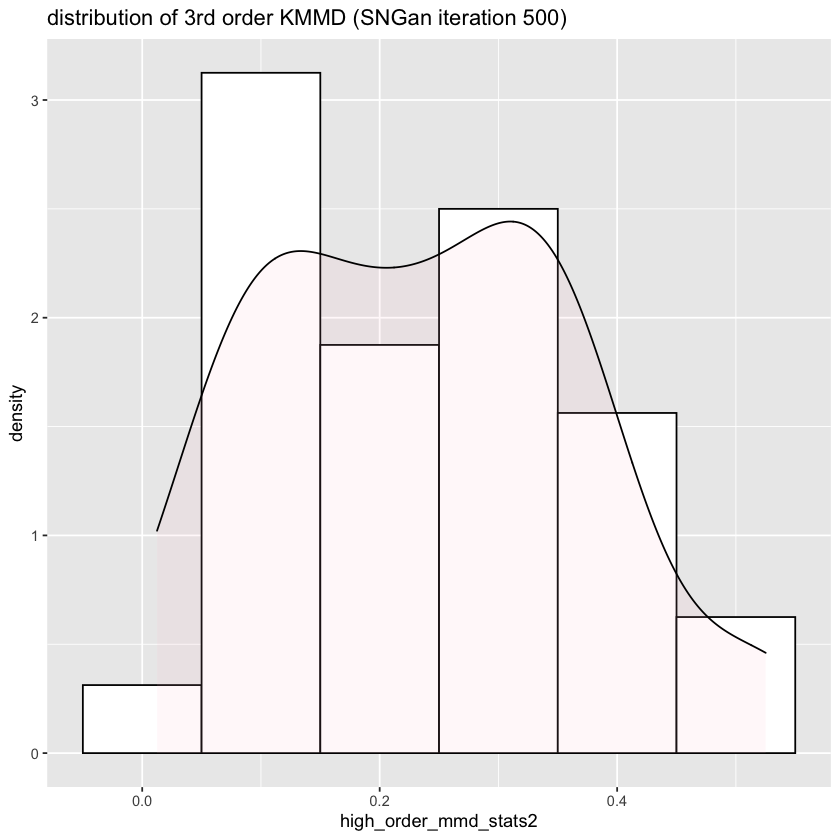

In [7]:
ggplot(df_high_order_mmd_stats2, aes(x=high_order_mmd_stats2)) +
    labs(title="distribution of 3rd order KMMD (SNGan iteration 500)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="pink")  # Overlay with transparent density plot

In [8]:
summary(df_low_order_mmd_stats2)

 low_order_mmd_stats2
 Min.   :0.1134      
 1st Qu.:0.3446      
 Median :0.4767      
 Mean   :0.4678      
 3rd Qu.:0.5790      
 Max.   :0.7262      

In [9]:
summary(df_high_order_mmd_stats2)

 high_order_mmd_stats2
 Min.   :0.01248      
 1st Qu.:0.11638      
 Median :0.22464      
 Mean   :0.23761      
 3rd Qu.:0.33200      
 Max.   :0.52510      

## Result of Face dataset for SNGan (iteration 500)

In [6]:
result2 = compute_kmmd("./sngan_face_results/input", "./sngan_face_results/iter_500")

H0.reject2 = result2$H0.reject
df_H0.reject2 = as.data.frame(H0.reject2) %>% group_by(H0.reject2) %>% count() %>% rename("inference_count"=n)
low_order_mmd_stats2 = result2$low_order_mmd_stats
df_low_order_mmd_stats2 = as.data.frame(low_order_mmd_stats2)
high_order_mmd_stats2 = result2$high_order_mmd_stats
df_high_order_mmd_stats2 = as.data.frame(high_order_mmd_stats2)

Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (

### Hypothesis test result 

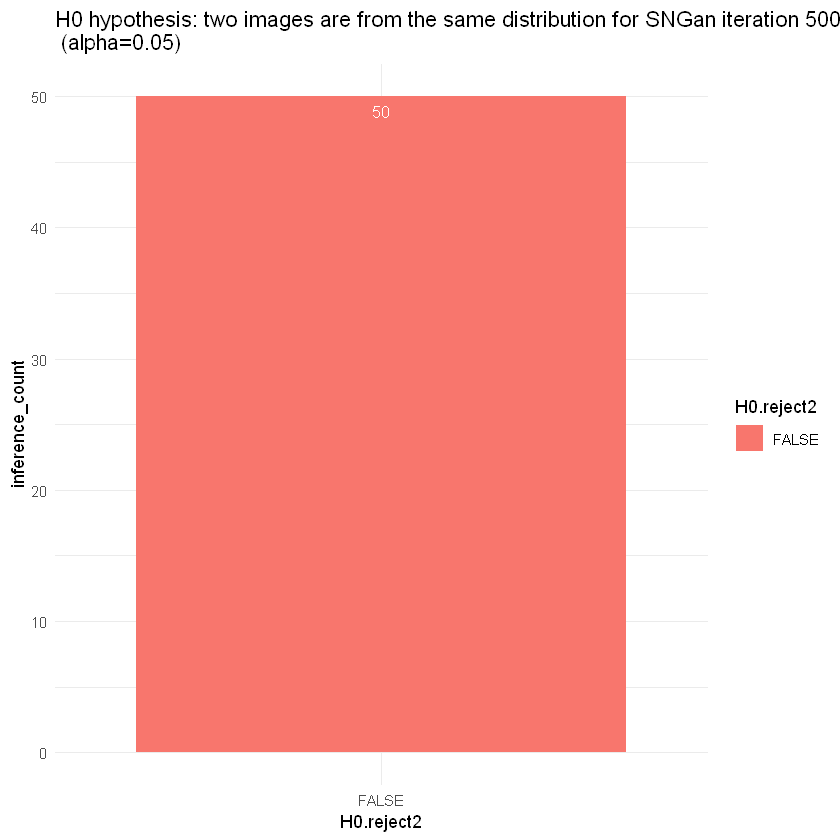

In [7]:
ggplot(data=df_H0.reject2, aes(x=H0.reject2, y=inference_count, fill=H0.reject2)) +
  labs(title="H0 hypothesis: two images are from the same distribution for SNGan iteration 500\n (alpha=0.05)") +
  geom_bar(stat="identity")+
  geom_text(aes(label=inference_count), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

### MMD statistics

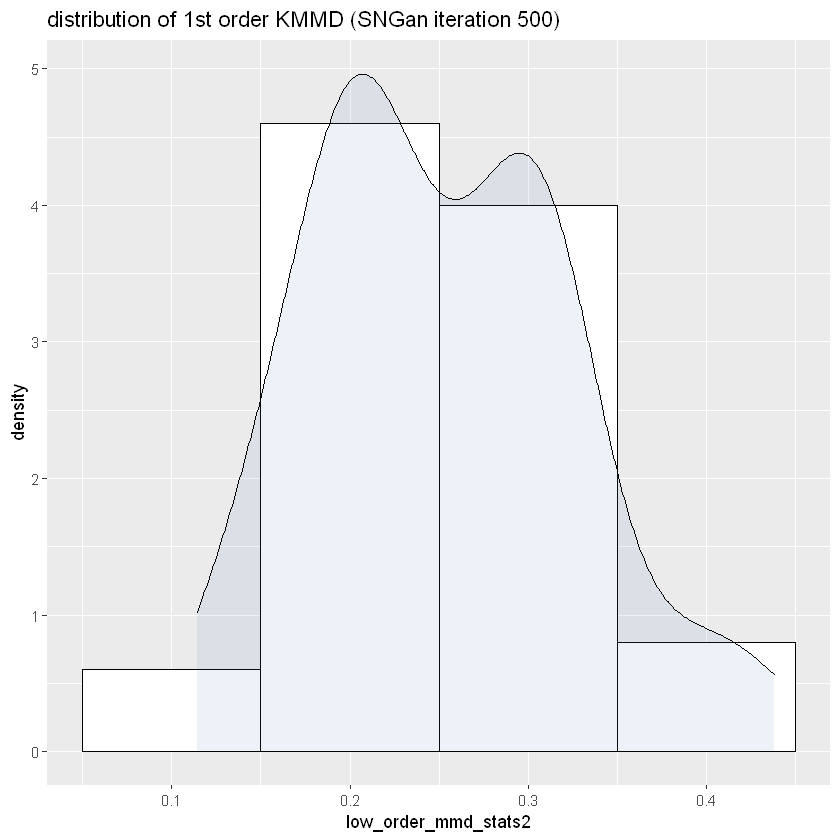

In [8]:
ggplot(df_low_order_mmd_stats2, aes(x=low_order_mmd_stats2)) +
    labs(title="distribution of 1st order KMMD (SNGan iteration 500)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="steelblue")  # Overlay with transparent density plot

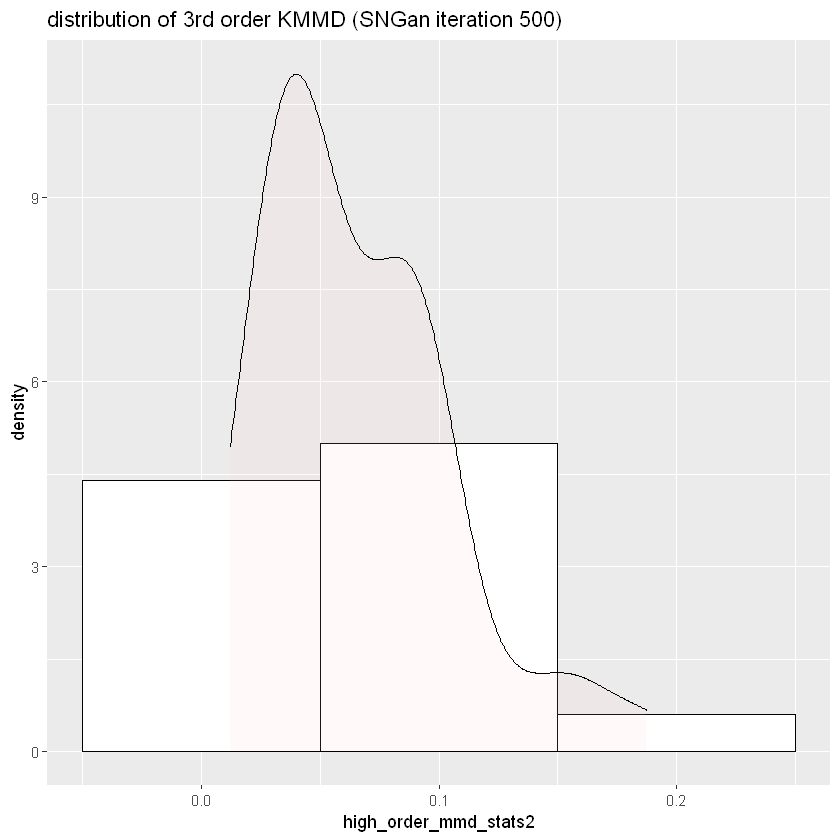

In [9]:
ggplot(df_high_order_mmd_stats2, aes(x=high_order_mmd_stats2)) +
    labs(title="distribution of 3rd order KMMD (SNGan iteration 500)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="pink")  # Overlay with transparent density plot

In [10]:
summary(df_low_order_mmd_stats2)

 low_order_mmd_stats2
 Min.   :0.1141      
 1st Qu.:0.1986      
 Median :0.2429      
 Mean   :0.2525      
 3rd Qu.:0.3082      
 Max.   :0.4382      

In [11]:
summary(df_high_order_mmd_stats2)

 high_order_mmd_stats2
 Min.   :0.01207      
 1st Qu.:0.03759      
 Median :0.05575      
 Mean   :0.06602      
 3rd Qu.:0.09131      
 Max.   :0.18750      

## Result of Anime dataset for SNGan (iteration 500)

In [12]:
result2 = compute_kmmd("./sngan_anime_results/input", "./sngan_anime_results/iter_500")

Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (

In [13]:
H0.reject2 = result2$H0.reject
df_H0.reject2 = as.data.frame(H0.reject2) %>% group_by(H0.reject2) %>% count() %>% rename("inference_count"=n)
low_order_mmd_stats2 = result2$low_order_mmd_stats
df_low_order_mmd_stats2 = as.data.frame(low_order_mmd_stats2)
high_order_mmd_stats2 = result2$high_order_mmd_stats
df_high_order_mmd_stats2 = as.data.frame(high_order_mmd_stats2)

### Hypothesis test result 

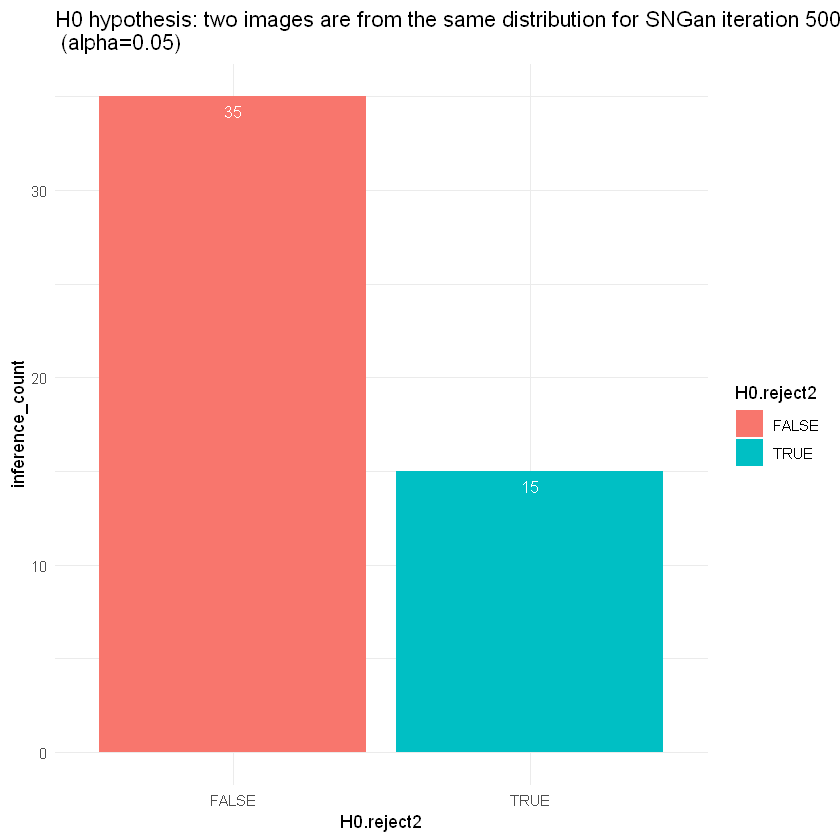

In [15]:
ggplot(data=df_H0.reject2, aes(x=H0.reject2, y=inference_count, fill=H0.reject2)) +
  labs(title="H0 hypothesis: two images are from the same distribution for SNGan iteration 500\n (alpha=0.05)") +
  geom_bar(stat="identity")+
  geom_text(aes(label=inference_count), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

### MMD statistics

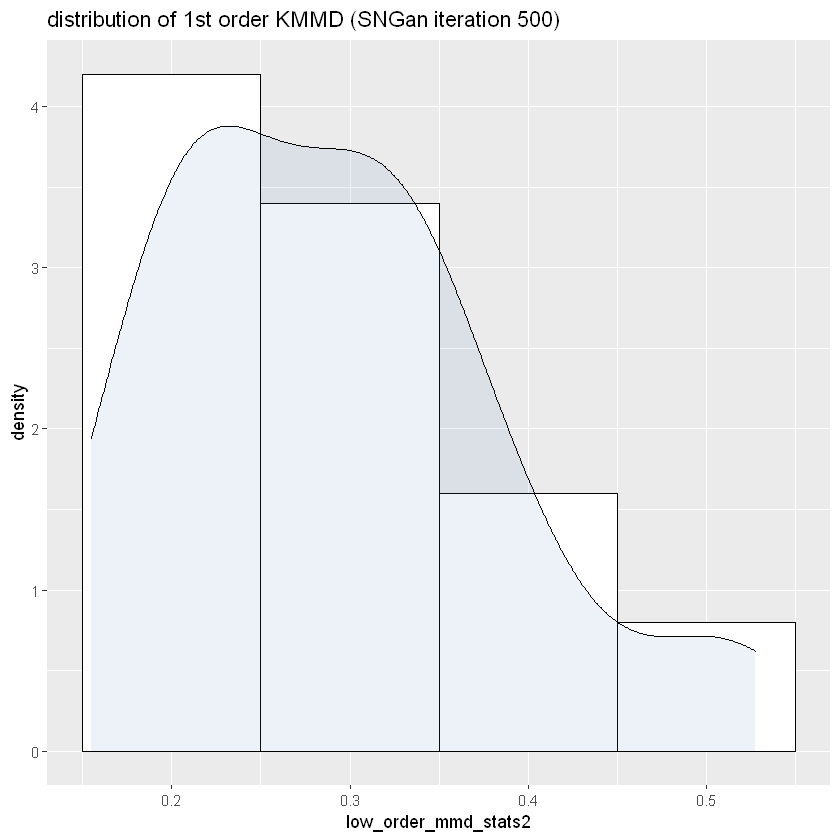

In [16]:
ggplot(df_low_order_mmd_stats2, aes(x=low_order_mmd_stats2)) +
    labs(title="distribution of 1st order KMMD (SNGan iteration 500)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="steelblue")  # Overlay with transparent density plot

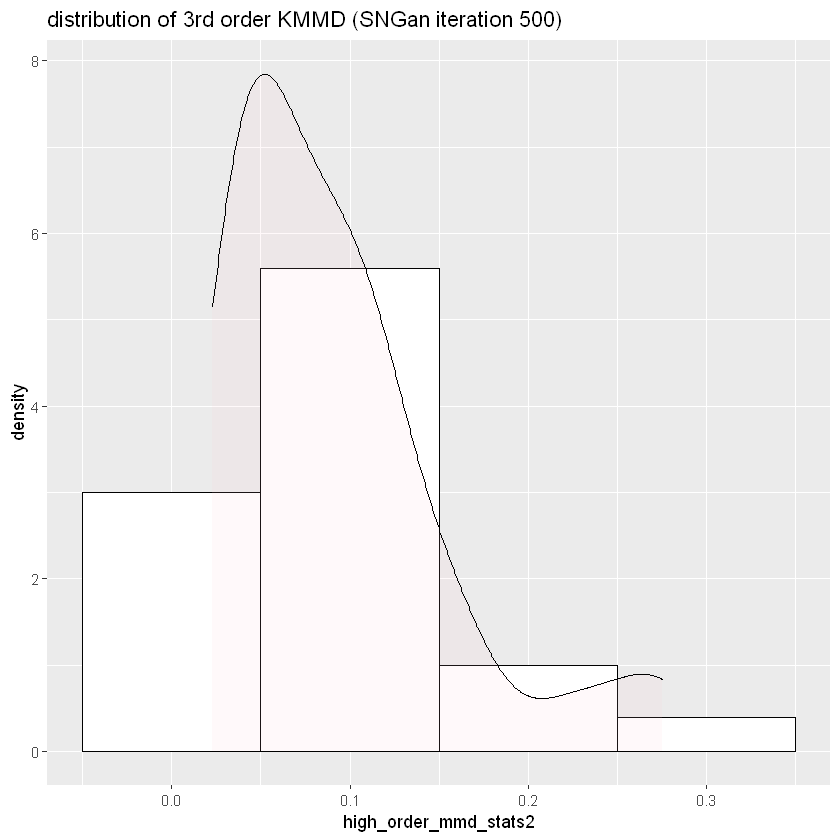

In [17]:
ggplot(df_high_order_mmd_stats2, aes(x=high_order_mmd_stats2)) +
    labs(title="distribution of 3rd order KMMD (SNGan iteration 500)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="pink")  # Overlay with transparent density plot

In [18]:
summary(df_low_order_mmd_stats2)

 low_order_mmd_stats2
 Min.   :0.1547      
 1st Qu.:0.2143      
 Median :0.2832      
 Mean   :0.2923      
 3rd Qu.:0.3451      
 Max.   :0.5278      

In [19]:
summary(df_high_order_mmd_stats2)

 high_order_mmd_stats2
 Min.   :0.02294      
 1st Qu.:0.04413      
 Median :0.07810      
 Mean   :0.09198      
 3rd Qu.:0.11654      
 Max.   :0.27561      

## Result of Flowers dataset for SNGan (iteration 2000)

In [20]:
result3 = compute_kmmd("./sngan_flower_results/input", "./sngan_flower_results/iter_2000")

Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (

In [21]:
H0.reject3 = result3$H0.reject
df_H0.reject3 = as.data.frame(H0.reject3) %>% group_by(H0.reject3) %>% count() %>% rename("inference_count"=n)
low_order_mmd_stats3 = result3$low_order_mmd_stats
df_low_order_mmd_stats3 = as.data.frame(low_order_mmd_stats3)
high_order_mmd_stats3 = result3$high_order_mmd_stats
df_high_order_mmd_stats3 = as.data.frame(high_order_mmd_stats3)

### Hypothesis test result

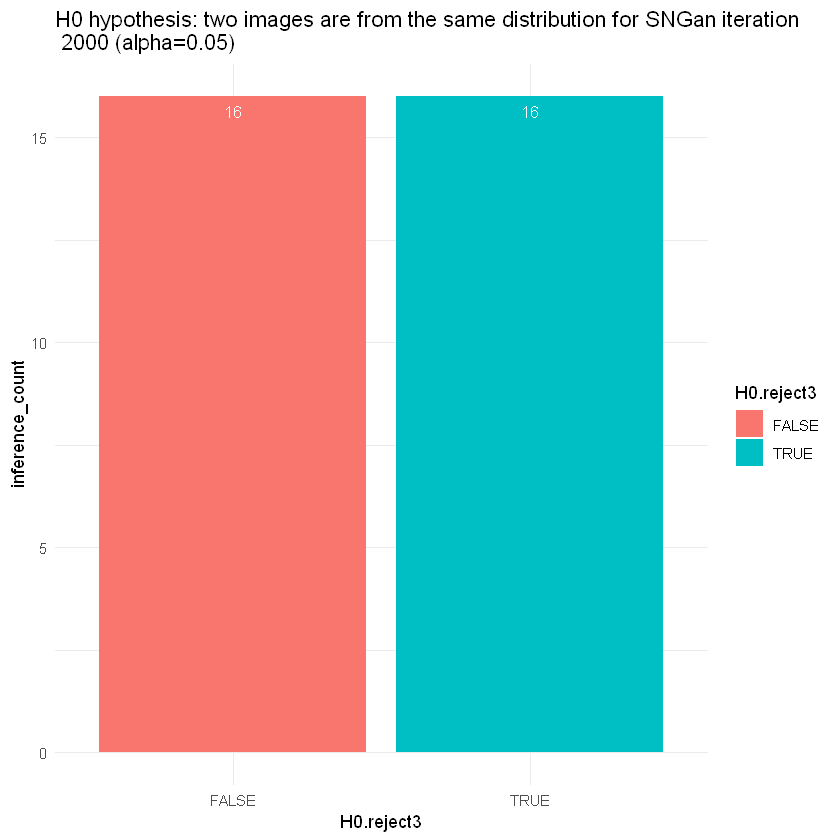

In [22]:
ggplot(data=df_H0.reject3, aes(x=H0.reject3, y=inference_count, fill=H0.reject3)) +
  labs(title="H0 hypothesis: two images are from the same distribution for SNGan iteration\n 2000 (alpha=0.05)") +
  geom_bar(stat="identity")+
  geom_text(aes(label=inference_count), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

### MMD statistics

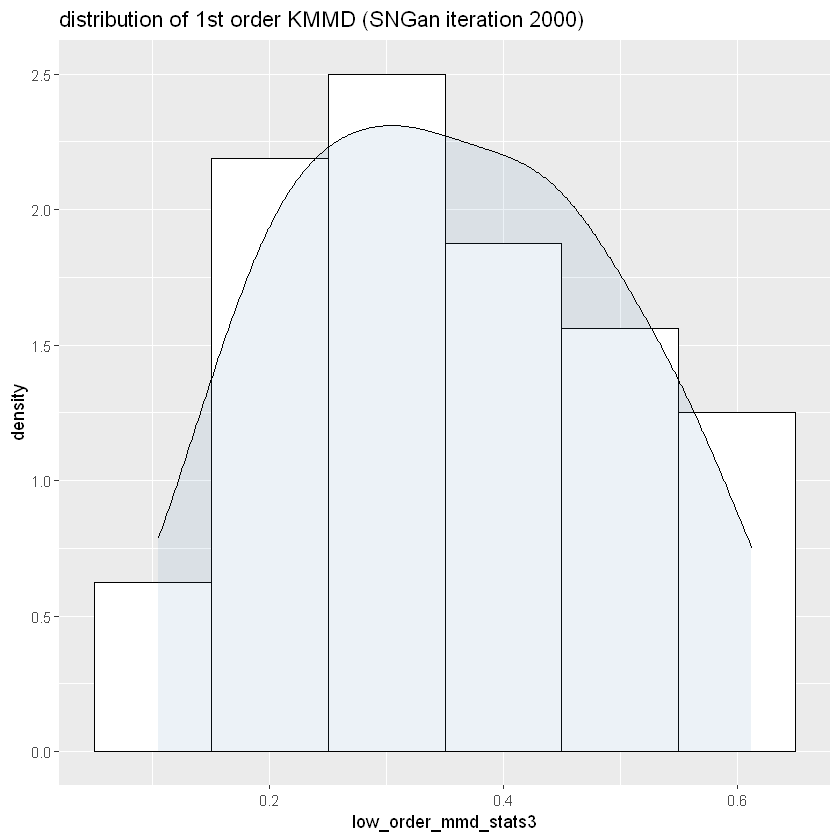

In [23]:
ggplot(df_low_order_mmd_stats3, aes(x=low_order_mmd_stats3)) +
    labs(title="distribution of 1st order KMMD (SNGan iteration 2000)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="steelblue")  # Overlay with transparent density plot

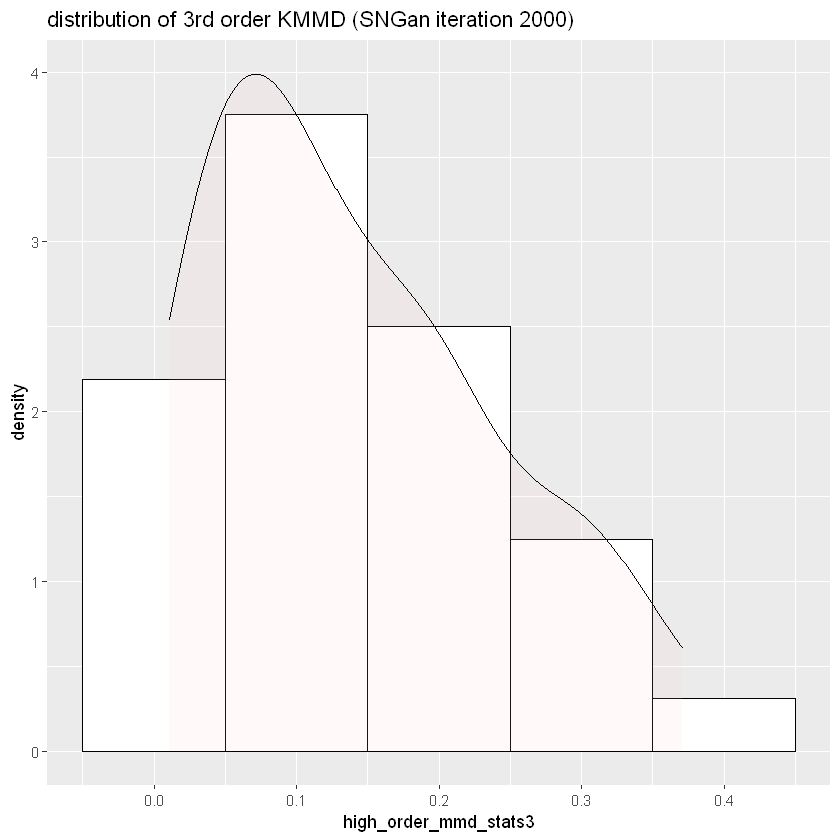

In [24]:
ggplot(df_high_order_mmd_stats3, aes(x=high_order_mmd_stats3)) +
    labs(title="distribution of 3rd order KMMD (SNGan iteration 2000)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="pink")  # Overlay with transparent density plot

In [25]:
summary(df_low_order_mmd_stats3)

 low_order_mmd_stats3
 Min.   :0.1050      
 1st Qu.:0.2437      
 Median :0.3428      
 Mean   :0.3525      
 3rd Qu.:0.4604      
 Max.   :0.6123      

In [26]:
summary(df_high_order_mmd_stats3)

 high_order_mmd_stats3
 Min.   :0.01075      
 1st Qu.:0.05812      
 Median :0.11494      
 Mean   :0.14001      
 3rd Qu.:0.20875      
 Max.   :0.37065      

## Result of Face dataset for SNGan (iteration 2000)

In [27]:
result3 = compute_kmmd("./sngan_face_results/input", "./sngan_face_results/iter_2000")

Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (

In [28]:
H0.reject3 = result3$H0.reject
df_H0.reject3 = as.data.frame(H0.reject3) %>% group_by(H0.reject3) %>% count() %>% rename("inference_count"=n)
low_order_mmd_stats3 = result3$low_order_mmd_stats
df_low_order_mmd_stats3 = as.data.frame(low_order_mmd_stats3)
high_order_mmd_stats3 = result3$high_order_mmd_stats
df_high_order_mmd_stats3 = as.data.frame(high_order_mmd_stats3)

### Hypothesis test result

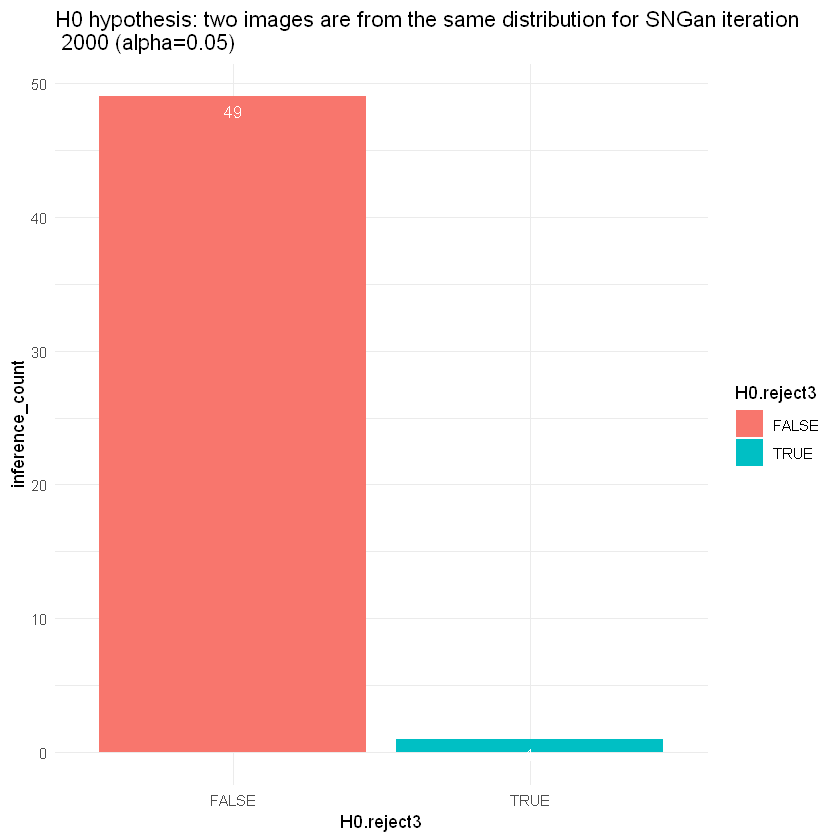

In [29]:
ggplot(data=df_H0.reject3, aes(x=H0.reject3, y=inference_count, fill=H0.reject3)) +
  labs(title="H0 hypothesis: two images are from the same distribution for SNGan iteration\n 2000 (alpha=0.05)") +
  geom_bar(stat="identity")+
  geom_text(aes(label=inference_count), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

### MMD statistics

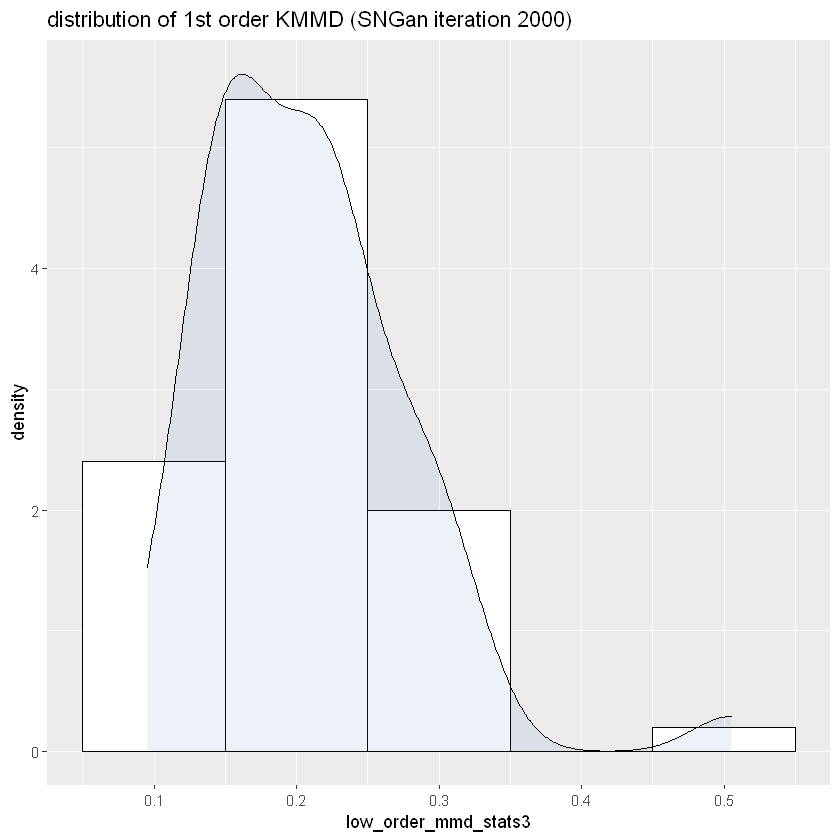

In [30]:
ggplot(df_low_order_mmd_stats3, aes(x=low_order_mmd_stats3)) +
    labs(title="distribution of 1st order KMMD (SNGan iteration 2000)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="steelblue")  # Overlay with transparent density plot

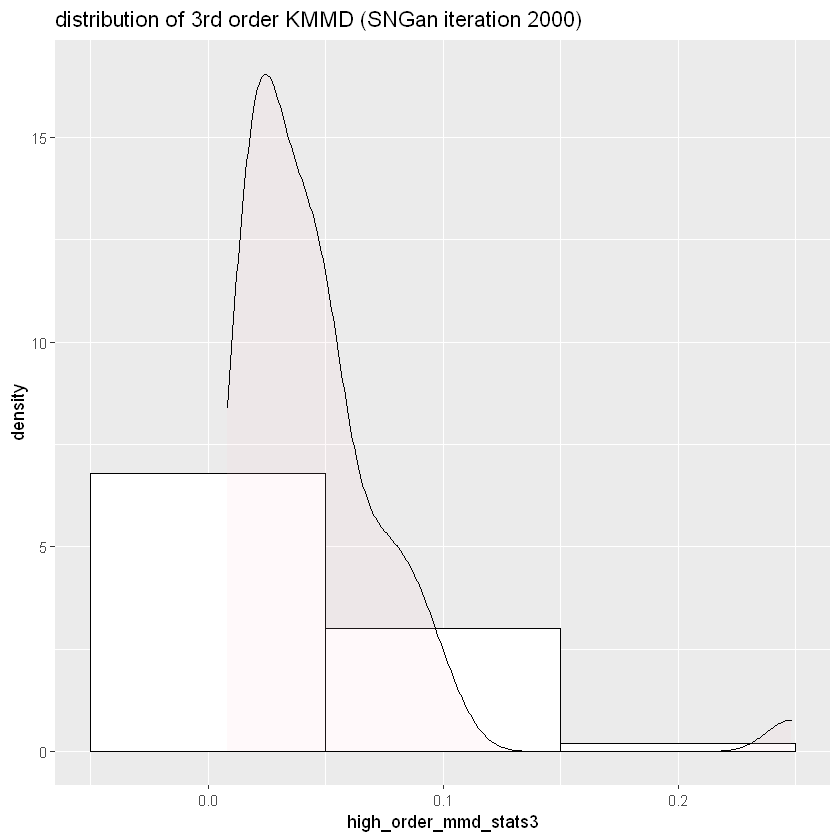

In [31]:
ggplot(df_high_order_mmd_stats3, aes(x=high_order_mmd_stats3)) +
    labs(title="distribution of 3rd order KMMD (SNGan iteration 2000)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="pink")  # Overlay with transparent density plot

In [32]:
summary(df_low_order_mmd_stats3)

 low_order_mmd_stats3
 Min.   :0.09513     
 1st Qu.:0.15050     
 Median :0.20370     
 Mean   :0.20815     
 3rd Qu.:0.24009     
 Max.   :0.50502     

In [33]:
summary(df_high_order_mmd_stats3)

 high_order_mmd_stats3
 Min.   :0.008101     
 1st Qu.:0.020882     
 Median :0.039048     
 Mean   :0.045939     
 3rd Qu.:0.054713     
 Max.   :0.248085     

## Result of Anime dataset for SNGan (iteration 2000)

In [34]:
result3 = compute_kmmd("./sngan_anime_results/input", "./sngan_anime_results/iter_2000")

Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (

In [39]:
H0.reject3 = result3$H0.reject
df_H0.reject3 = as.data.frame(H0.reject3) %>% group_by(H0.reject3) %>% count() %>% rename("inference_count"=n)
low_order_mmd_stats3 = result3$low_order_mmd_stats
df_low_order_mmd_stats3 = as.data.frame(low_order_mmd_stats3)
high_order_mmd_stats3 = result3$high_order_mmd_stats
df_high_order_mmd_stats3 = as.data.frame(high_order_mmd_stats3)

### Hypothesis test result

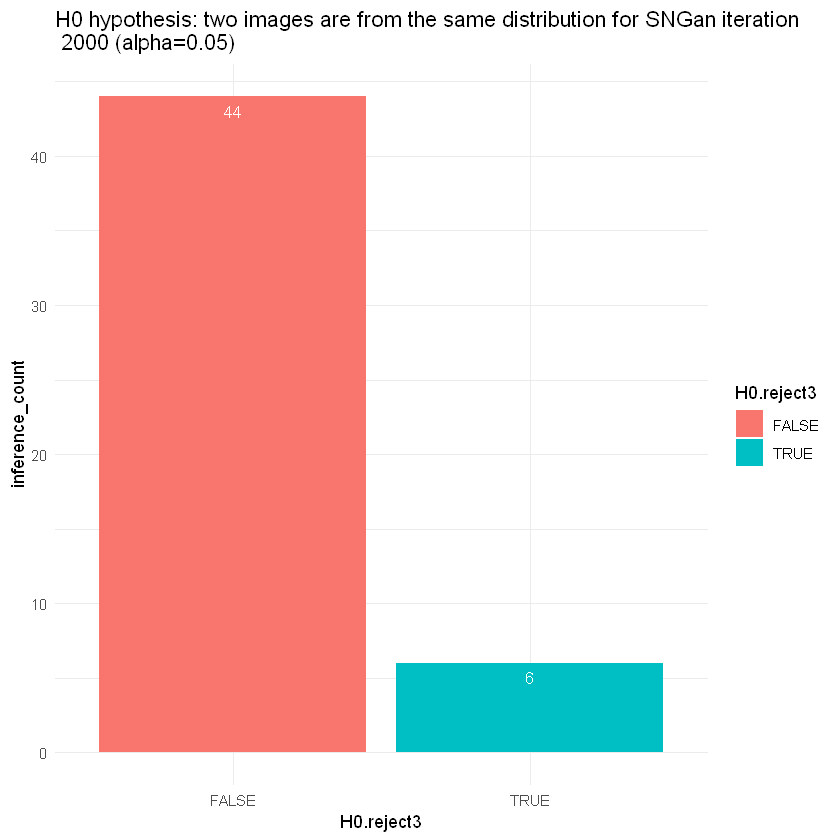

In [40]:
ggplot(data=df_H0.reject3, aes(x=H0.reject3, y=inference_count, fill=H0.reject3)) +
  labs(title="H0 hypothesis: two images are from the same distribution for SNGan iteration\n 2000 (alpha=0.05)") +
  geom_bar(stat="identity")+
  geom_text(aes(label=inference_count), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

### MMD statistics

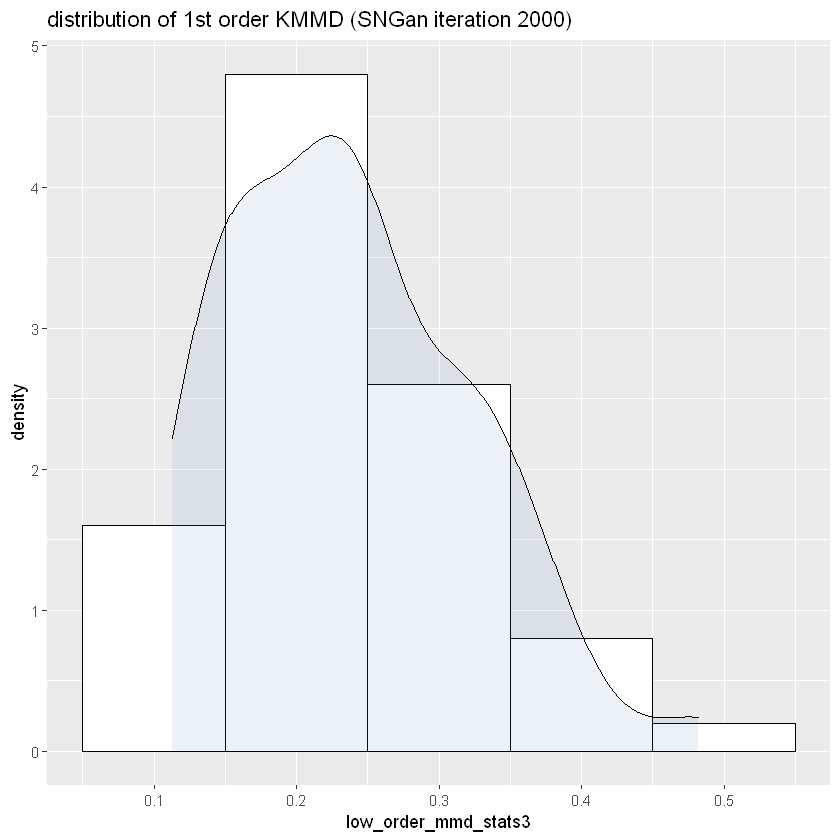

In [41]:
ggplot(df_low_order_mmd_stats3, aes(x=low_order_mmd_stats3)) +
    labs(title="distribution of 1st order KMMD (SNGan iteration 2000)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="steelblue")  # Overlay with transparent density plot

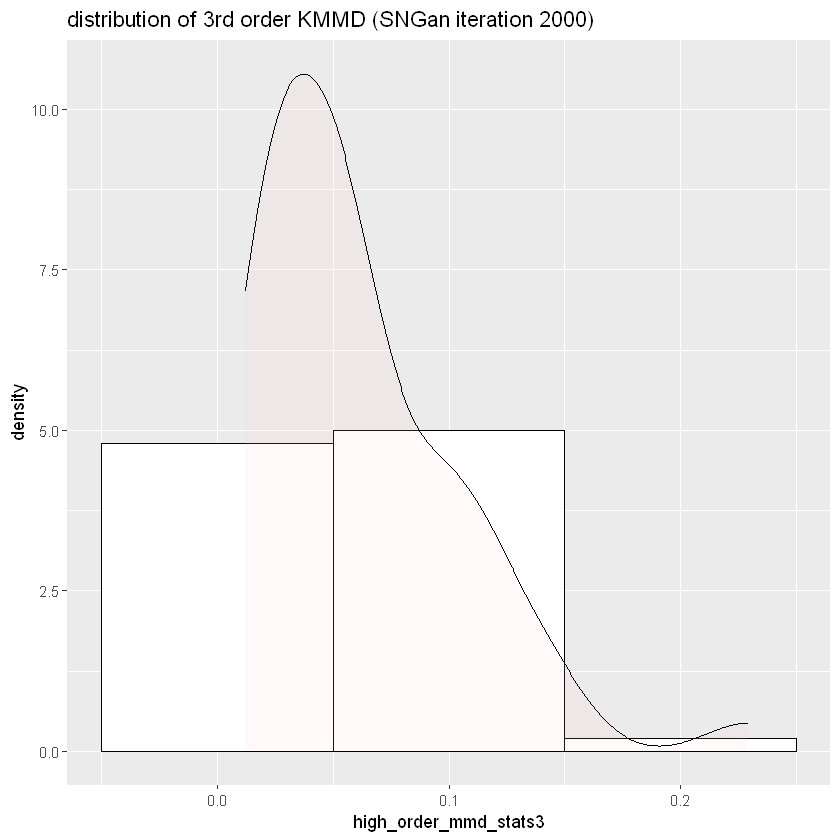

In [42]:
ggplot(df_high_order_mmd_stats3, aes(x=high_order_mmd_stats3)) +
    labs(title="distribution of 3rd order KMMD (SNGan iteration 2000)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="pink")  # Overlay with transparent density plot

In [43]:
summary(df_low_order_mmd_stats3)

 low_order_mmd_stats3
 Min.   :0.1128      
 1st Qu.:0.1638      
 Median :0.2326      
 Mean   :0.2372      
 3rd Qu.:0.2961      
 Max.   :0.4818      

In [44]:
summary(df_high_order_mmd_stats3)

 high_order_mmd_stats3
 Min.   :0.01215      
 1st Qu.:0.02558      
 Median :0.05234      
 Mean   :0.06125      
 3rd Qu.:0.08578      
 Max.   :0.22912      

## Result of Flowers dataset for SNGan (iteration 5000)

In [45]:
result4 = compute_kmmd("./sngan_flower_results/input", "./sngan_flower_results/iter_5000")

Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (

In [46]:
H0.reject4 = result4$H0.reject
df_H0.reject4 = as.data.frame(H0.reject4) %>% group_by(H0.reject4) %>% count() %>% rename("inference_count"=n)
low_order_mmd_stats4 = result4$low_order_mmd_stats
df_low_order_mmd_stats4 = as.data.frame(low_order_mmd_stats4)
high_order_mmd_stats4 = result4$high_order_mmd_stats
df_high_order_mmd_stats4 = as.data.frame(high_order_mmd_stats4)

### Hypothesis test result

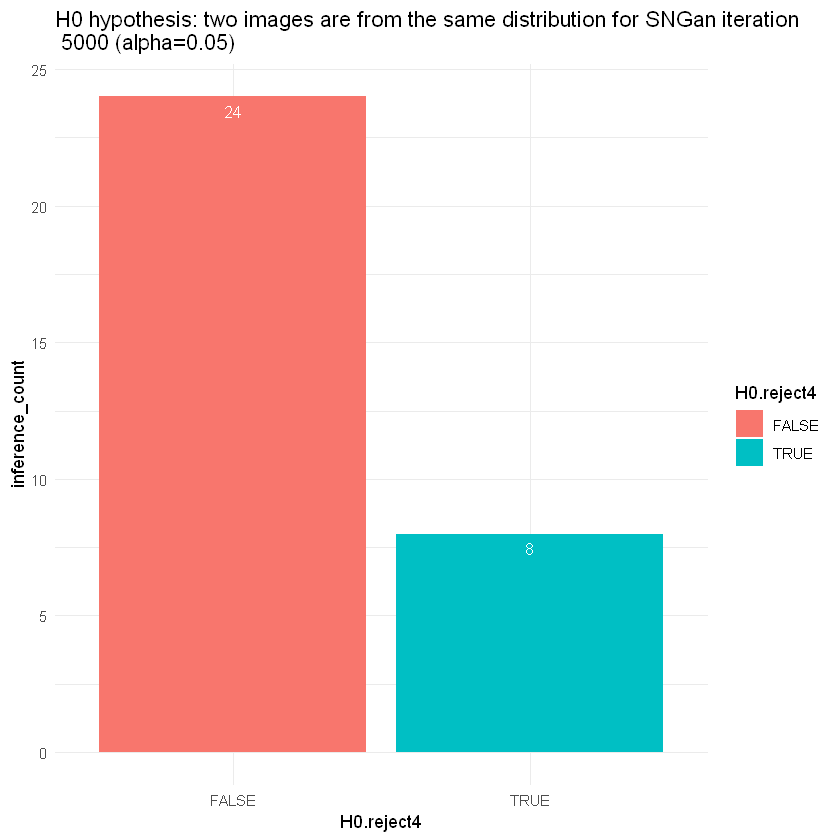

In [47]:
ggplot(data=df_H0.reject4, aes(x=H0.reject4, y=inference_count, fill=H0.reject4)) +
  labs(title="H0 hypothesis: two images are from the same distribution for SNGan iteration\n 5000 (alpha=0.05)") +
  geom_bar(stat="identity")+
  geom_text(aes(label=inference_count), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

### MMD statistics

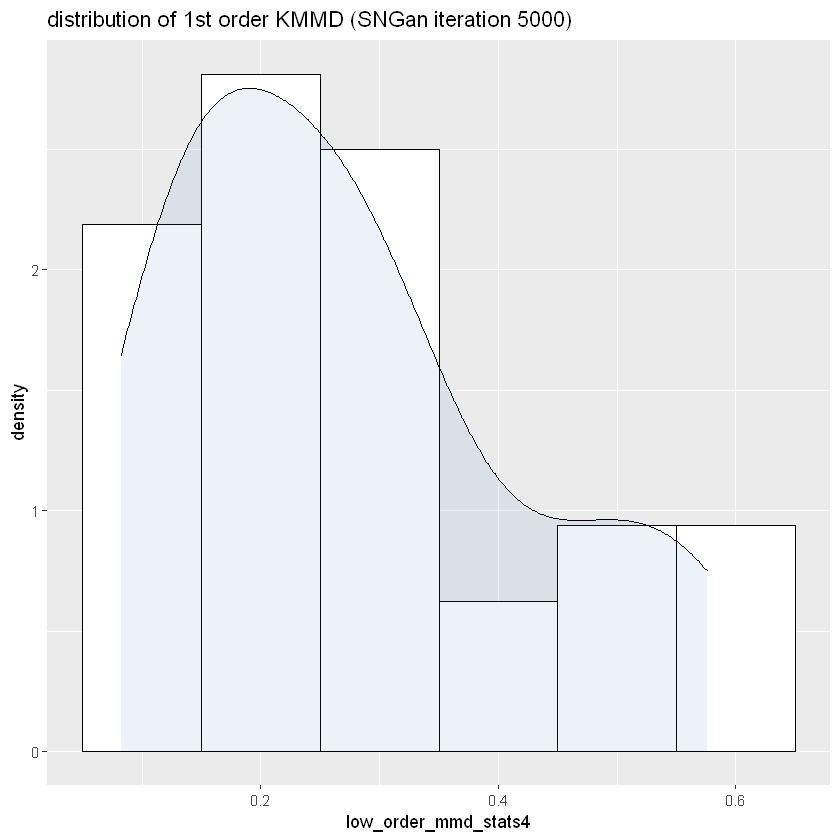

In [48]:
ggplot(df_low_order_mmd_stats4, aes(x=low_order_mmd_stats4)) +
    labs(title="distribution of 1st order KMMD (SNGan iteration 5000)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="steelblue")  # Overlay with transparent density plot

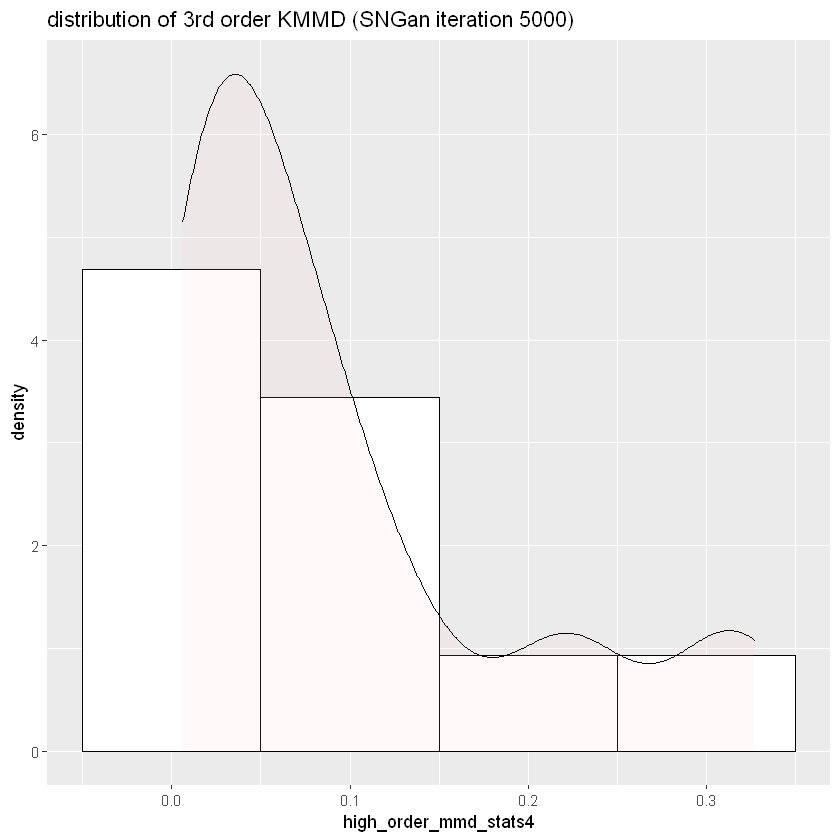

In [49]:
ggplot(df_high_order_mmd_stats4, aes(x=high_order_mmd_stats4)) +
    labs(title="distribution of 3rd order KMMD (SNGan iteration 5000)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="pink")  # Overlay with transparent density plot

In [50]:
summary(df_low_order_mmd_stats4)

 low_order_mmd_stats4
 Min.   :0.08221     
 1st Qu.:0.15313     
 Median :0.24500     
 Mean   :0.27322     
 3rd Qu.:0.34510     
 Max.   :0.57584     

In [51]:
summary(df_high_order_mmd_stats4)

 high_order_mmd_stats4
 Min.   :0.006196     
 1st Qu.:0.022311     
 Median :0.058128     
 Mean   :0.093146     
 3rd Qu.:0.116364     
 Max.   :0.327304     

## Result of Face dataset for SNGan (iteration 5000)

In [52]:
result4 = compute_kmmd("./sngan_face_results/input", "./sngan_face_results/iter_5000")

Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (

In [53]:
H0.reject4 = result4$H0.reject
df_H0.reject4 = as.data.frame(H0.reject4) %>% group_by(H0.reject4) %>% count() %>% rename("inference_count"=n)
low_order_mmd_stats4 = result4$low_order_mmd_stats
df_low_order_mmd_stats4 = as.data.frame(low_order_mmd_stats4)
high_order_mmd_stats4 = result4$high_order_mmd_stats
df_high_order_mmd_stats4 = as.data.frame(high_order_mmd_stats4)

### Hypothesis test result

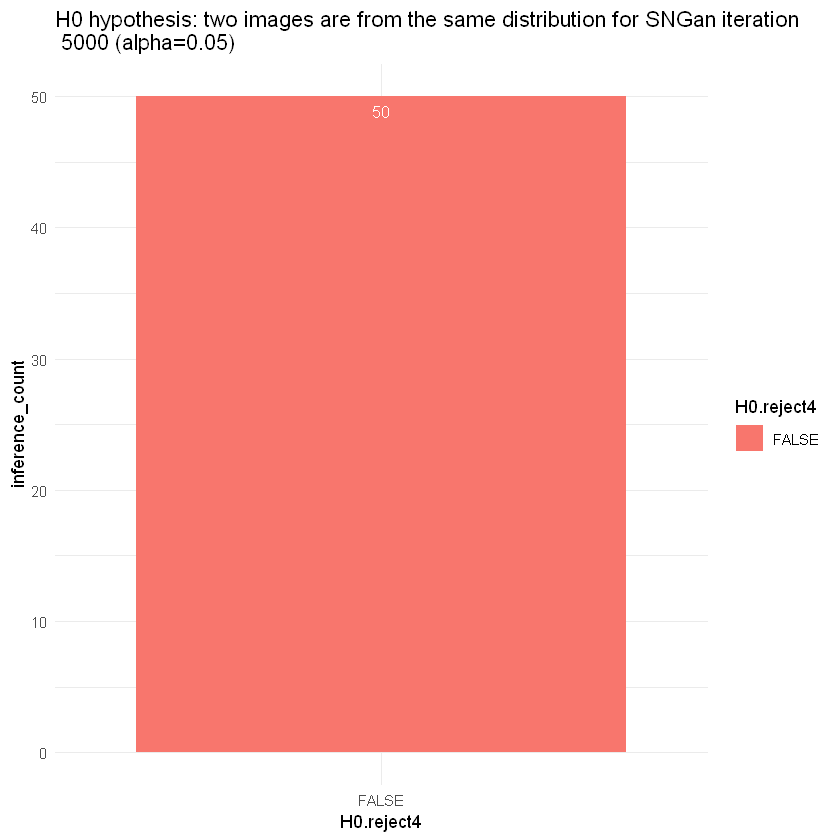

In [54]:
ggplot(data=df_H0.reject4, aes(x=H0.reject4, y=inference_count, fill=H0.reject4)) +
  labs(title="H0 hypothesis: two images are from the same distribution for SNGan iteration\n 5000 (alpha=0.05)") +
  geom_bar(stat="identity")+
  geom_text(aes(label=inference_count), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

### MMD statistics

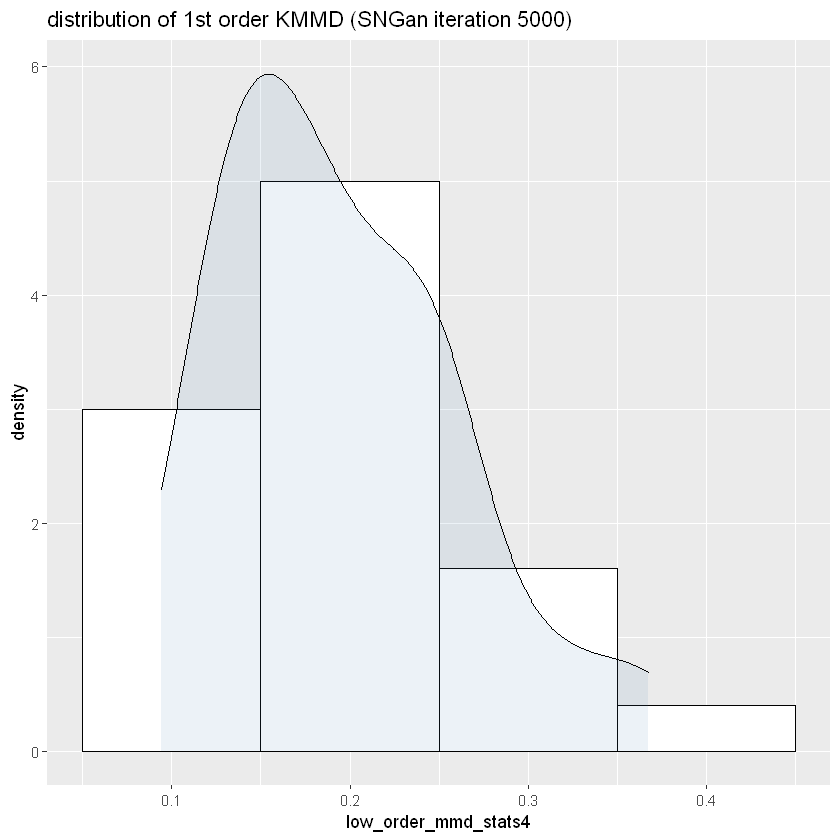

In [55]:
ggplot(df_low_order_mmd_stats4, aes(x=low_order_mmd_stats4)) +
    labs(title="distribution of 1st order KMMD (SNGan iteration 5000)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="steelblue")  # Overlay with transparent density plot

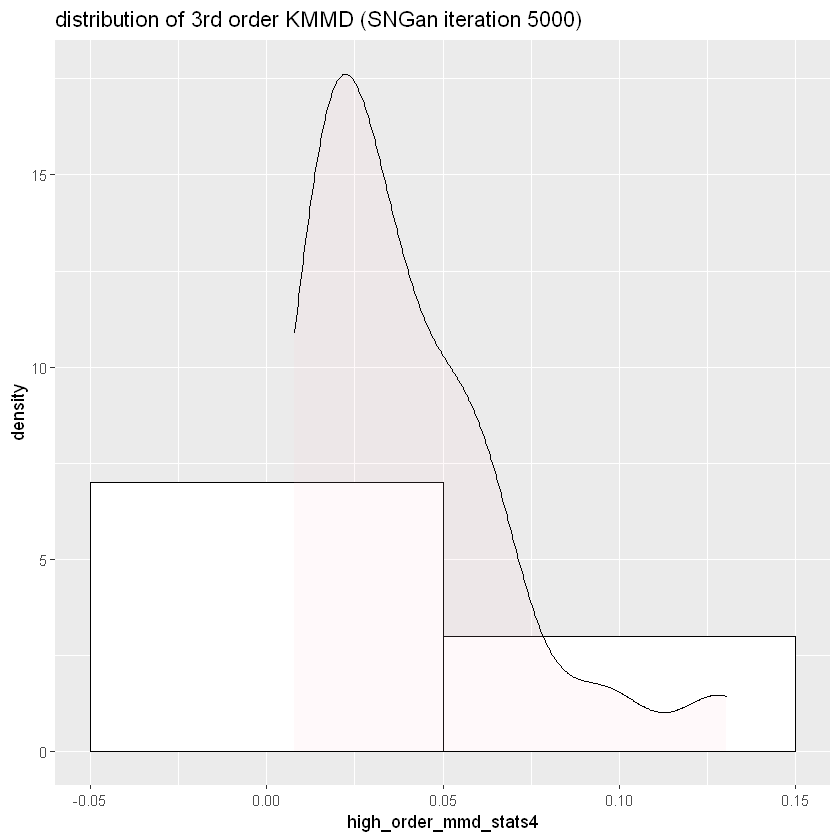

In [56]:
ggplot(df_high_order_mmd_stats4, aes(x=high_order_mmd_stats4)) +
    labs(title="distribution of 3rd order KMMD (SNGan iteration 5000)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="pink")  # Overlay with transparent density plot

In [57]:
summary(df_low_order_mmd_stats4)

 low_order_mmd_stats4
 Min.   :0.09433     
 1st Qu.:0.14044     
 Median :0.18524     
 Mean   :0.19491     
 3rd Qu.:0.23649     
 Max.   :0.36736     

In [58]:
summary(df_high_order_mmd_stats4)

 high_order_mmd_stats4
 Min.   :0.007909     
 1st Qu.:0.018253     
 Median :0.032325     
 Mean   :0.039961     
 3rd Qu.:0.053585     
 Max.   :0.130525     

## Result of anime dataset for SNGan (iteration 5000)

In [59]:
result4 = compute_kmmd("./sngan_anime_results/input", "./sngan_anime_results/iter_5000")

Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (

In [60]:
H0.reject4 = result4$H0.reject
df_H0.reject4 = as.data.frame(H0.reject4) %>% group_by(H0.reject4) %>% count() %>% rename("inference_count"=n)
low_order_mmd_stats4 = result4$low_order_mmd_stats
df_low_order_mmd_stats4 = as.data.frame(low_order_mmd_stats4)
high_order_mmd_stats4 = result4$high_order_mmd_stats
df_high_order_mmd_stats4 = as.data.frame(high_order_mmd_stats4)

### Hypothesis test result

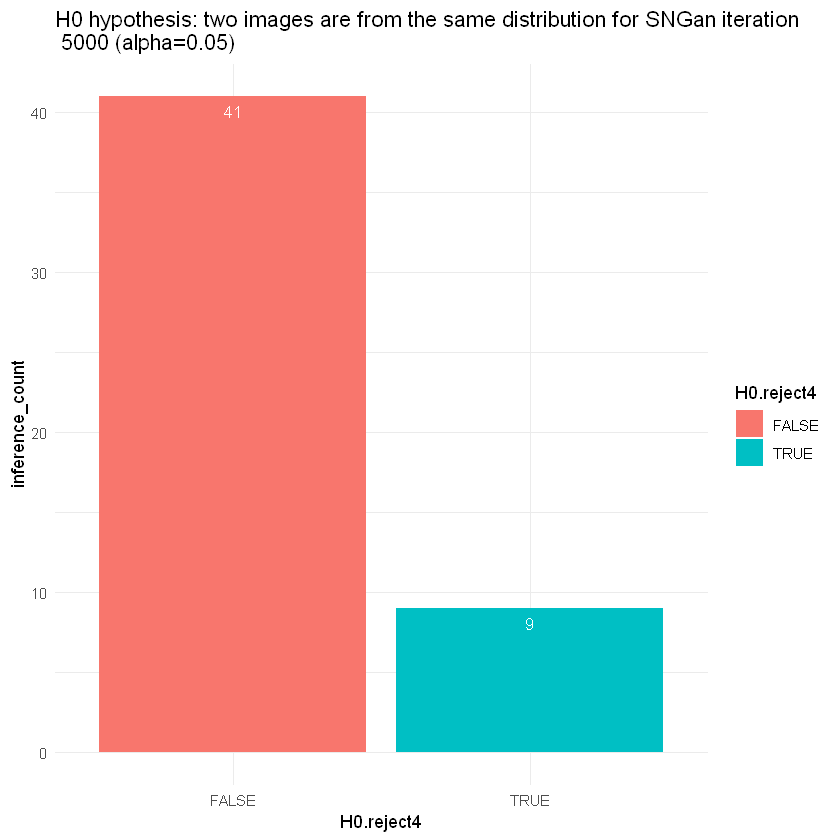

In [61]:
ggplot(data=df_H0.reject4, aes(x=H0.reject4, y=inference_count, fill=H0.reject4)) +
  labs(title="H0 hypothesis: two images are from the same distribution for SNGan iteration\n 5000 (alpha=0.05)") +
  geom_bar(stat="identity")+
  geom_text(aes(label=inference_count), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

In [62]:
### MMD statistics

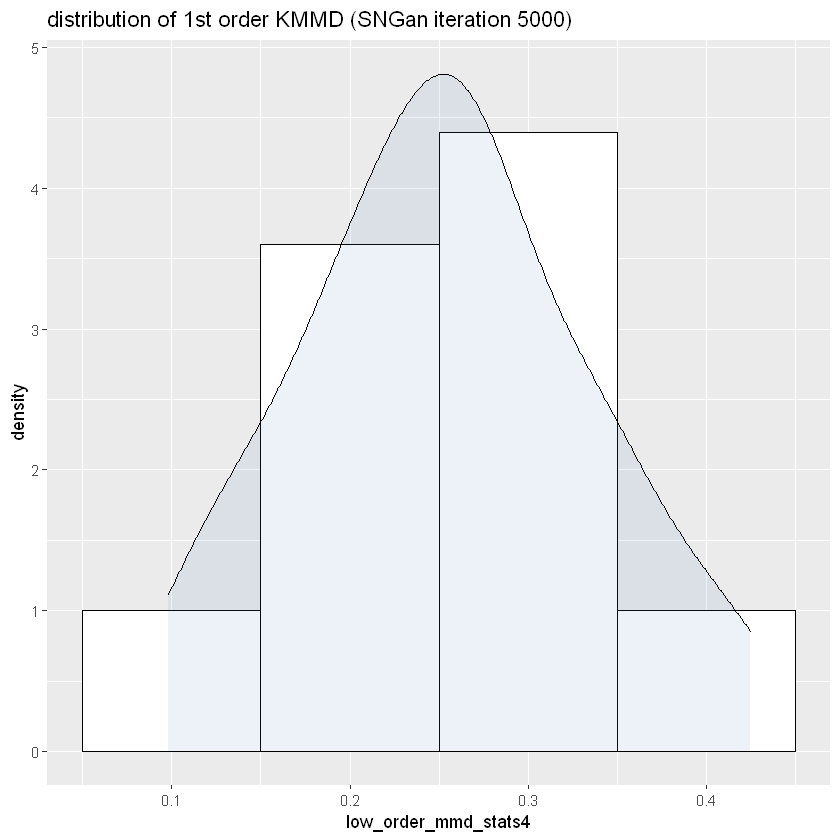

In [63]:
ggplot(df_low_order_mmd_stats4, aes(x=low_order_mmd_stats4)) +
    labs(title="distribution of 1st order KMMD (SNGan iteration 5000)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="steelblue")  # Overlay with transparent density plot

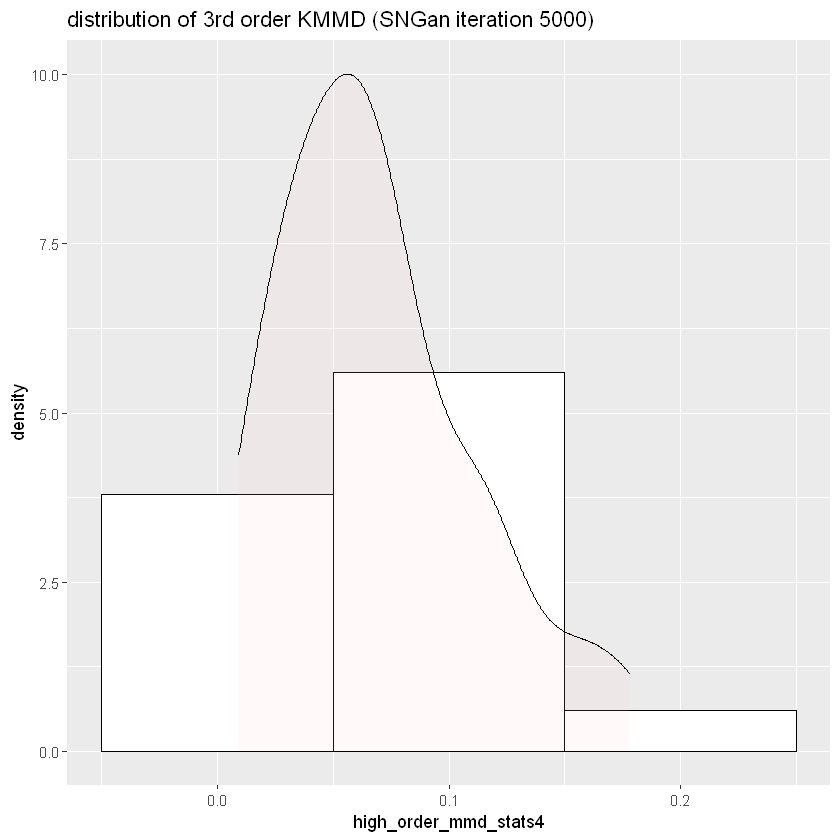

In [64]:
ggplot(df_high_order_mmd_stats4, aes(x=high_order_mmd_stats4)) +
    labs(title="distribution of 3rd order KMMD (SNGan iteration 5000)") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="pink")  # Overlay with transparent density plot

In [65]:
summary(df_low_order_mmd_stats4)

 low_order_mmd_stats4
 Min.   :0.09808     
 1st Qu.:0.19764     
 Median :0.25452     
 Mean   :0.25366     
 3rd Qu.:0.30486     
 Max.   :0.42495     

In [66]:
summary(df_high_order_mmd_stats4)

 high_order_mmd_stats4
 Min.   :0.009135     
 1st Qu.:0.037675     
 Median :0.062997     
 Mean   :0.068799     
 3rd Qu.:0.090967     
 Max.   :0.177984     

## Result of datasets for BigGan (iteration 500)

### flowers

In [47]:
result_flowers = compute_kmmd("./biggan_flower_results/input", "./biggan_flower_results/iter_500")

Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (

In [48]:
H0.reject = result_flowers$H0.reject
df_H0.reject = as.data.frame(H0.reject) %>% group_by(H0.reject) %>% count() %>% rename("inference_count"=n)
low_order_mmd_stats = result_flowers$low_order_mmd_stats
df_low_order_mmd_stats = as.data.frame(low_order_mmd_stats)
high_order_mmd_stats = result_flowers$high_order_mmd_stats
df_high_order_mmd_stats = as.data.frame(high_order_mmd_stats)

#### Hypothesis test result

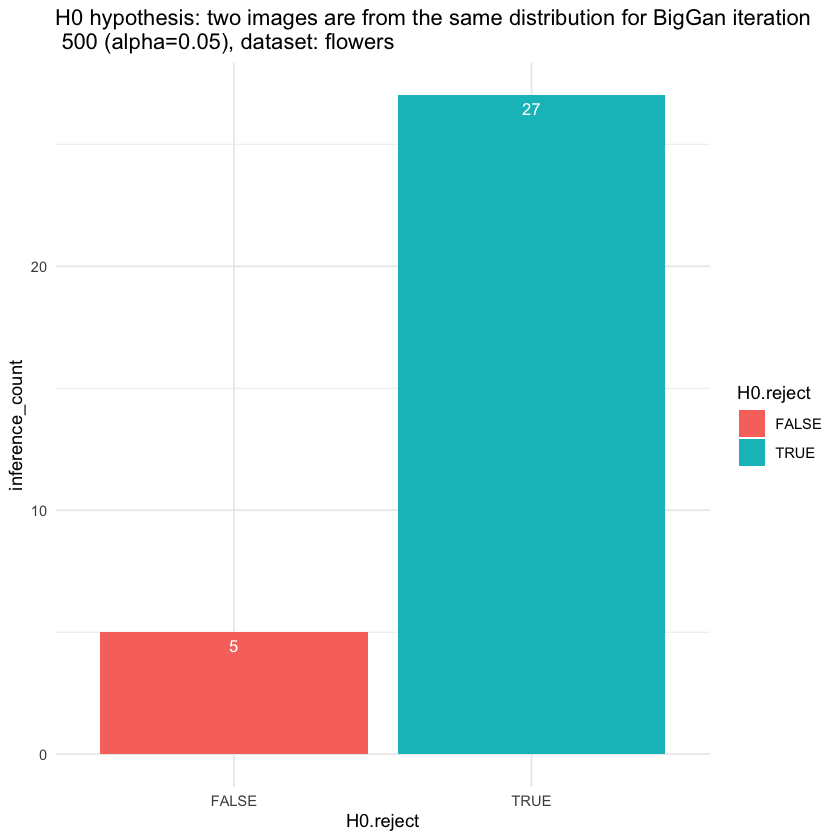

In [49]:
ggplot(data=df_H0.reject, aes(x=H0.reject, y=inference_count, fill=H0.reject)) +
  labs(title="H0 hypothesis: two images are from the same distribution for BigGan iteration\n 500 (alpha=0.05), dataset: flowers") +
  geom_bar(stat="identity")+
  geom_text(aes(label=inference_count), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

#### MMD statistics

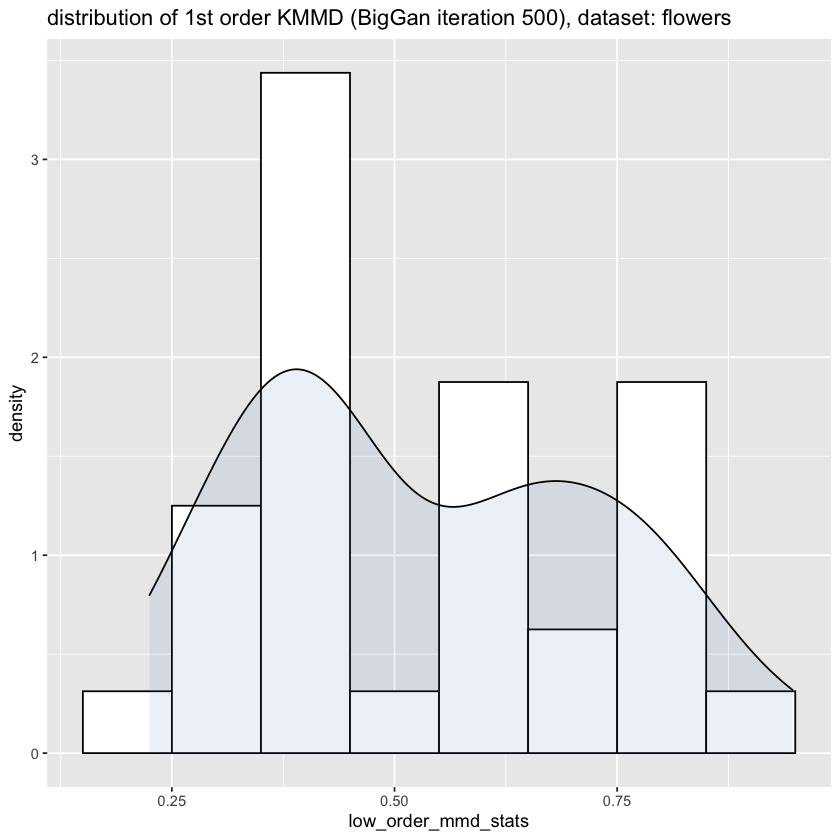

In [50]:
ggplot(df_low_order_mmd_stats, aes(x=low_order_mmd_stats)) +
    labs(title="distribution of 1st order KMMD (BigGan iteration 500), dataset: flowers") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="steelblue")  # Overlay with transparent density plot

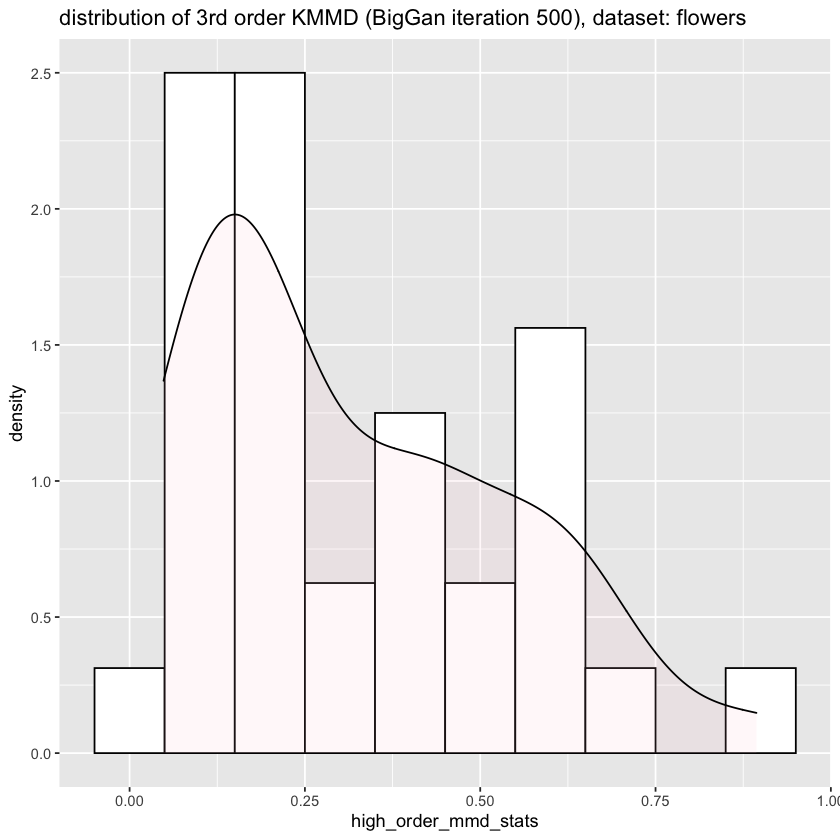

In [51]:
ggplot(df_high_order_mmd_stats, aes(x=high_order_mmd_stats)) +
    labs(title="distribution of 3rd order KMMD (BigGan iteration 500), dataset: flowers") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="pink")  # Overlay with transparent density plot

In [52]:
summary(df_low_order_mmd_stats)

 low_order_mmd_stats
 Min.   :0.2248     
 1st Qu.:0.3795     
 Median :0.4479     
 Mean   :0.5321     
 3rd Qu.:0.6763     
 Max.   :0.9469     

In [53]:
summary(df_high_order_mmd_stats)

 high_order_mmd_stats
 Min.   :0.04844     
 1st Qu.:0.14069     
 Median :0.19715     
 Mean   :0.31712     
 3rd Qu.:0.45411     
 Max.   :0.89385     

### face

In [54]:
result_face = compute_kmmd("./biggan_face_results/input", "./biggan_face_results/iter_500")

Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (

In [55]:
H0.reject = result_face$H0.reject
df_H0.reject = as.data.frame(H0.reject) %>% group_by(H0.reject) %>% count() %>% rename("inference_count"=n)
low_order_mmd_stats = result_face$low_order_mmd_stats
df_low_order_mmd_stats = as.data.frame(low_order_mmd_stats)
high_order_mmd_stats = result_face$high_order_mmd_stats
df_high_order_mmd_stats = as.data.frame(high_order_mmd_stats)

#### Hypothesis test result

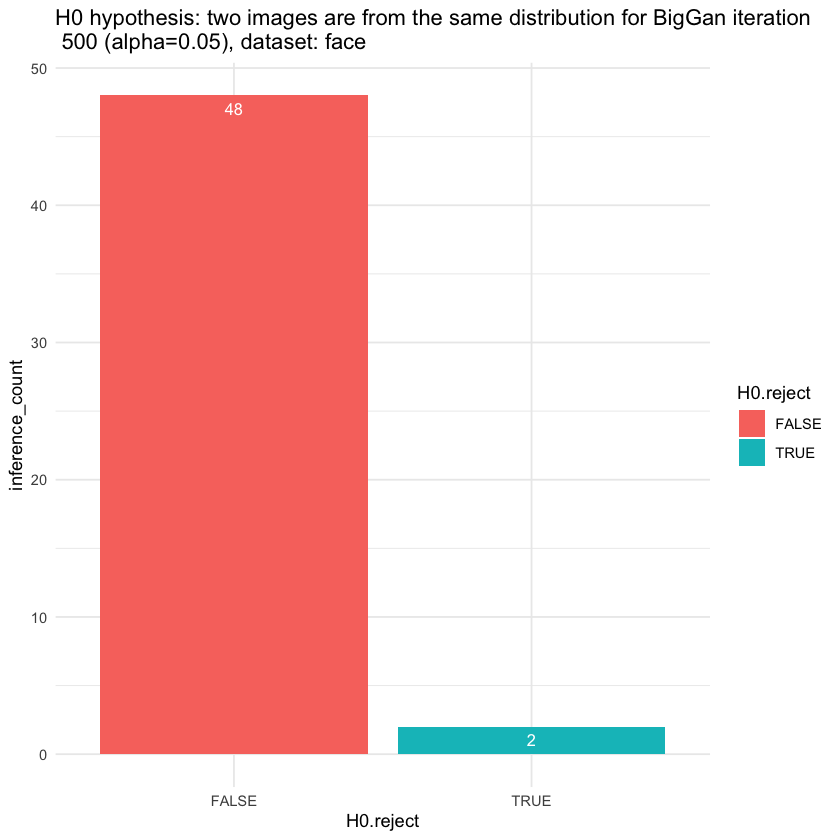

In [56]:
ggplot(data=df_H0.reject, aes(x=H0.reject, y=inference_count, fill=H0.reject)) +
  labs(title="H0 hypothesis: two images are from the same distribution for BigGan iteration\n 500 (alpha=0.05), dataset: face") +
  geom_bar(stat="identity")+
  geom_text(aes(label=inference_count), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

#### MMD statistics

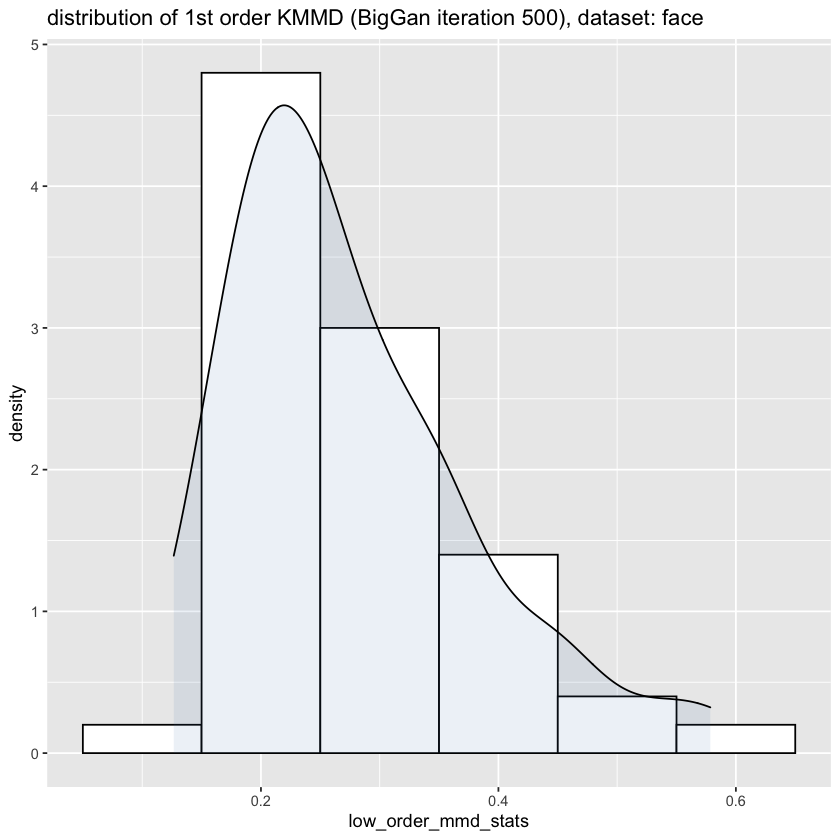

In [57]:
ggplot(df_low_order_mmd_stats, aes(x=low_order_mmd_stats)) +
    labs(title="distribution of 1st order KMMD (BigGan iteration 500), dataset: face") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="steelblue")  # Overlay with transparent density plot

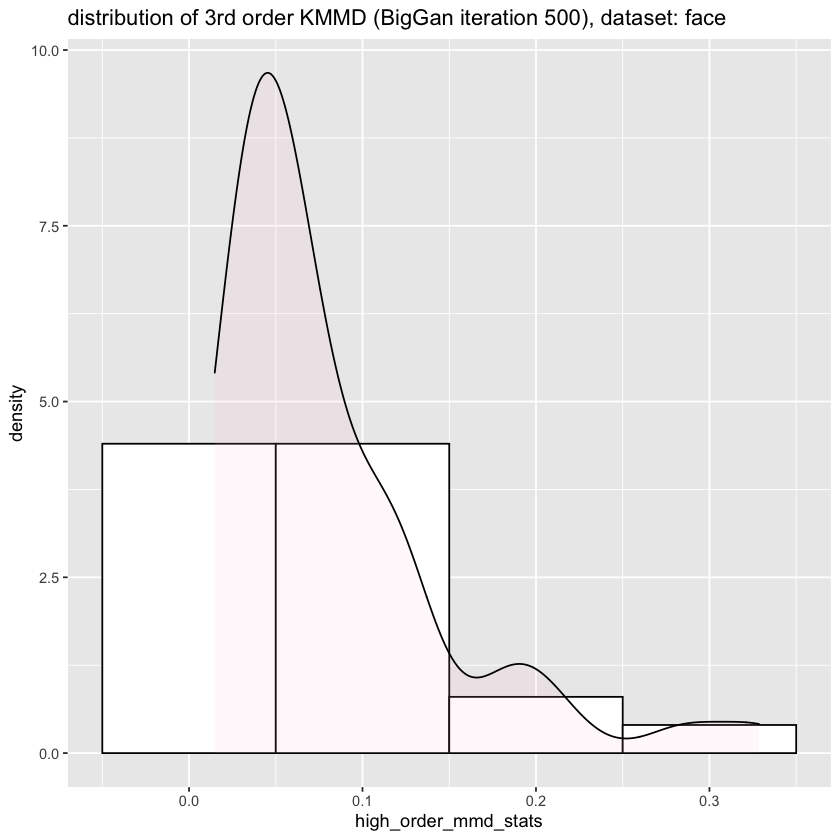

In [58]:
ggplot(df_high_order_mmd_stats, aes(x=high_order_mmd_stats)) +
    labs(title="distribution of 3rd order KMMD (BigGan iteration 500), dataset: face") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="pink")  # Overlay with transparent density plot

In [59]:
summary(df_low_order_mmd_stats)

 low_order_mmd_stats
 Min.   :0.1266     
 1st Qu.:0.2016     
 Median :0.2501     
 Mean   :0.2749     
 3rd Qu.:0.3377     
 Max.   :0.5785     

In [60]:
summary(df_high_order_mmd_stats)

 high_order_mmd_stats
 Min.   :0.01481     
 1st Qu.:0.03831     
 Median :0.05865     
 Mean   :0.08169     
 3rd Qu.:0.11010     
 Max.   :0.32857     

### anime

In [63]:
result_anime = compute_kmmd("./biggan_anime_results/input", "./biggan_anime_results/iter_500")

Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (

In [64]:
H0.reject = result_anime$H0.reject
df_H0.reject = as.data.frame(H0.reject) %>% group_by(H0.reject) %>% count() %>% rename("inference_count"=n)
low_order_mmd_stats = result_anime$low_order_mmd_stats
df_low_order_mmd_stats = as.data.frame(low_order_mmd_stats)
high_order_mmd_stats = result_anime$high_order_mmd_stats
df_high_order_mmd_stats = as.data.frame(high_order_mmd_stats)

#### Hypothesis test result

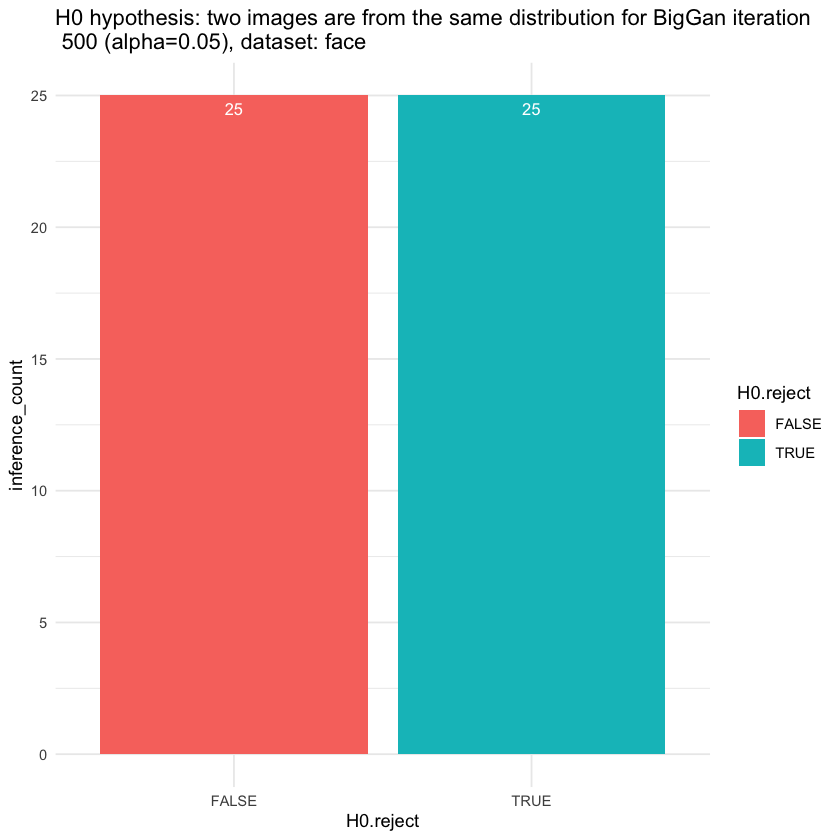

In [65]:
ggplot(data=df_H0.reject, aes(x=H0.reject, y=inference_count, fill=H0.reject)) +
  labs(title="H0 hypothesis: two images are from the same distribution for BigGan iteration\n 500 (alpha=0.05), dataset: face") +
  geom_bar(stat="identity")+
  geom_text(aes(label=inference_count), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

#### MMD statistics

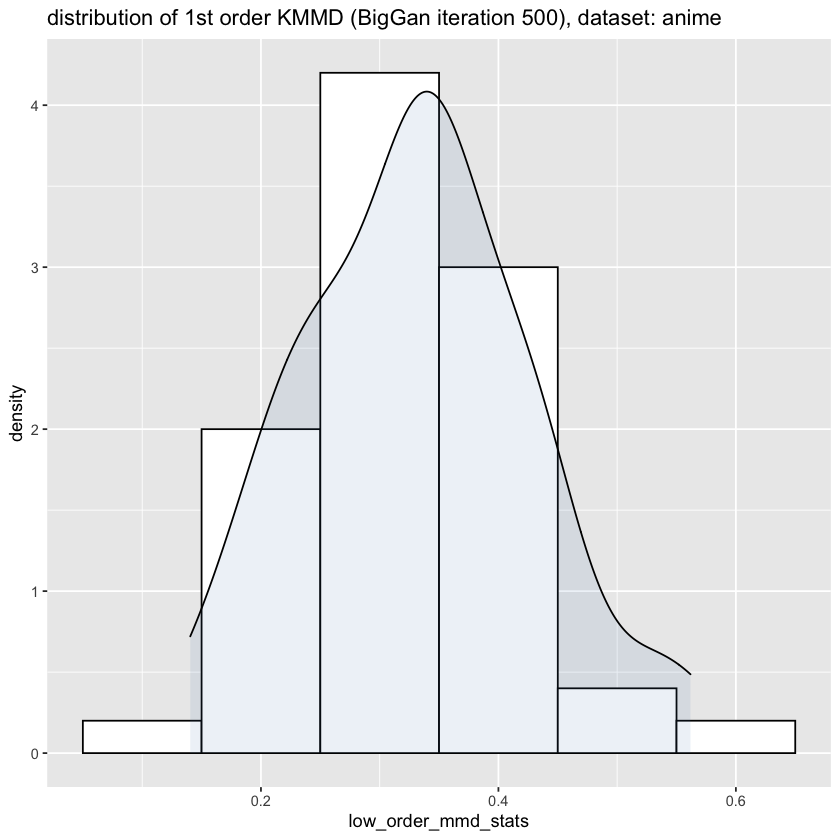

In [66]:
ggplot(df_low_order_mmd_stats, aes(x=low_order_mmd_stats)) +
    labs(title="distribution of 1st order KMMD (BigGan iteration 500), dataset: anime") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="steelblue")  # Overlay with transparent density plot

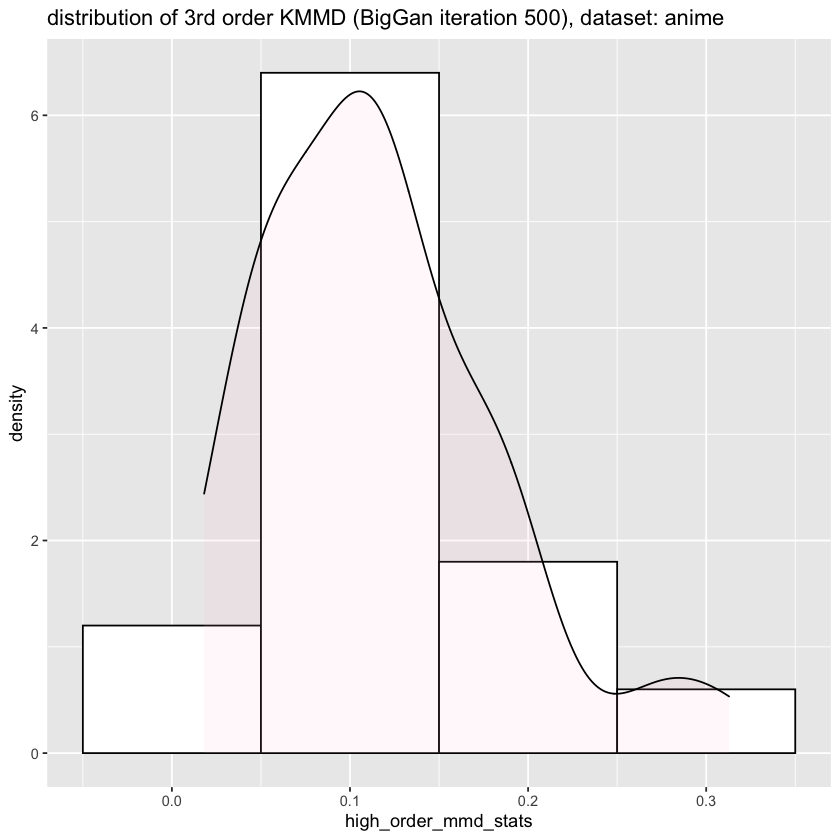

In [67]:
ggplot(df_high_order_mmd_stats, aes(x=high_order_mmd_stats)) +
    labs(title="distribution of 3rd order KMMD (BigGan iteration 500), dataset: anime") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="pink")  # Overlay with transparent density plot

In [68]:
summary(df_low_order_mmd_stats)

 low_order_mmd_stats
 Min.   :0.1405     
 1st Qu.:0.2549     
 Median :0.3414     
 Mean   :0.3319     
 3rd Qu.:0.3872     
 Max.   :0.5618     

In [69]:
summary(df_high_order_mmd_stats)

 high_order_mmd_stats
 Min.   :0.01810     
 1st Qu.:0.06274     
 Median :0.11402     
 Mean   :0.11651     
 3rd Qu.:0.14738     
 Max.   :0.31285     

## Result of datasets for BigGan (iteration 2000)

### flowers

In [70]:
result_flowers = compute_kmmd("./biggan_flower_results/input", "./biggan_flower_results/iter_2000")

Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (

In [71]:
H0.reject = result_flowers$H0.reject
df_H0.reject = as.data.frame(H0.reject) %>% group_by(H0.reject) %>% count() %>% rename("inference_count"=n)
low_order_mmd_stats = result_flowers$low_order_mmd_stats
df_low_order_mmd_stats = as.data.frame(low_order_mmd_stats)
high_order_mmd_stats = result_flowers$high_order_mmd_stats
df_high_order_mmd_stats = as.data.frame(high_order_mmd_stats)

#### Hypothesis test result

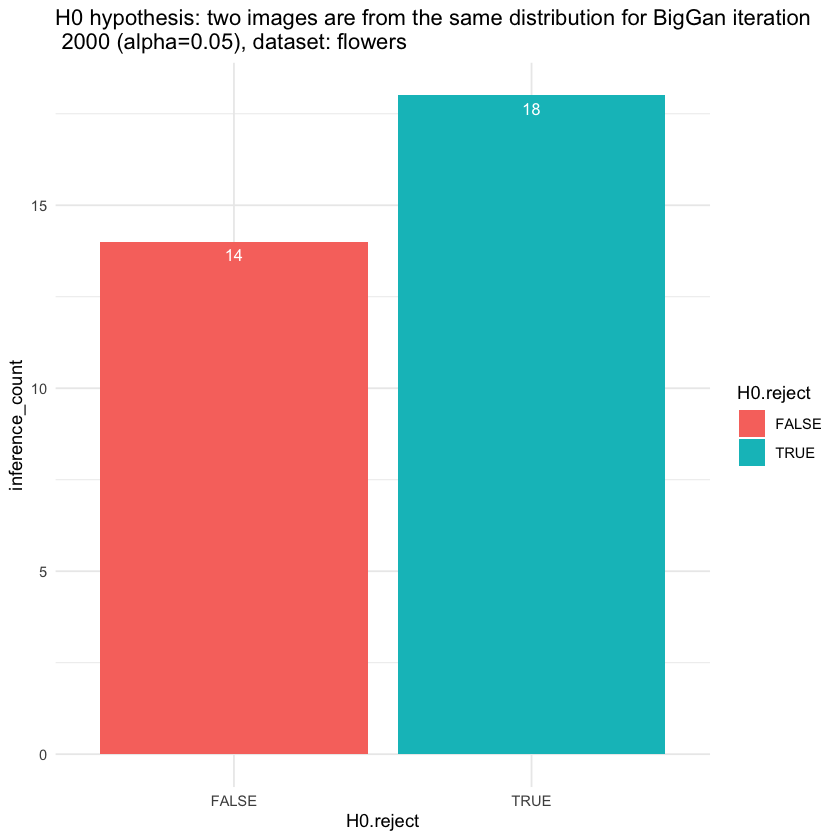

In [72]:
ggplot(data=df_H0.reject, aes(x=H0.reject, y=inference_count, fill=H0.reject)) +
  labs(title="H0 hypothesis: two images are from the same distribution for BigGan iteration\n 2000 (alpha=0.05), dataset: flowers") +
  geom_bar(stat="identity")+
  geom_text(aes(label=inference_count), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

#### MMD statistics

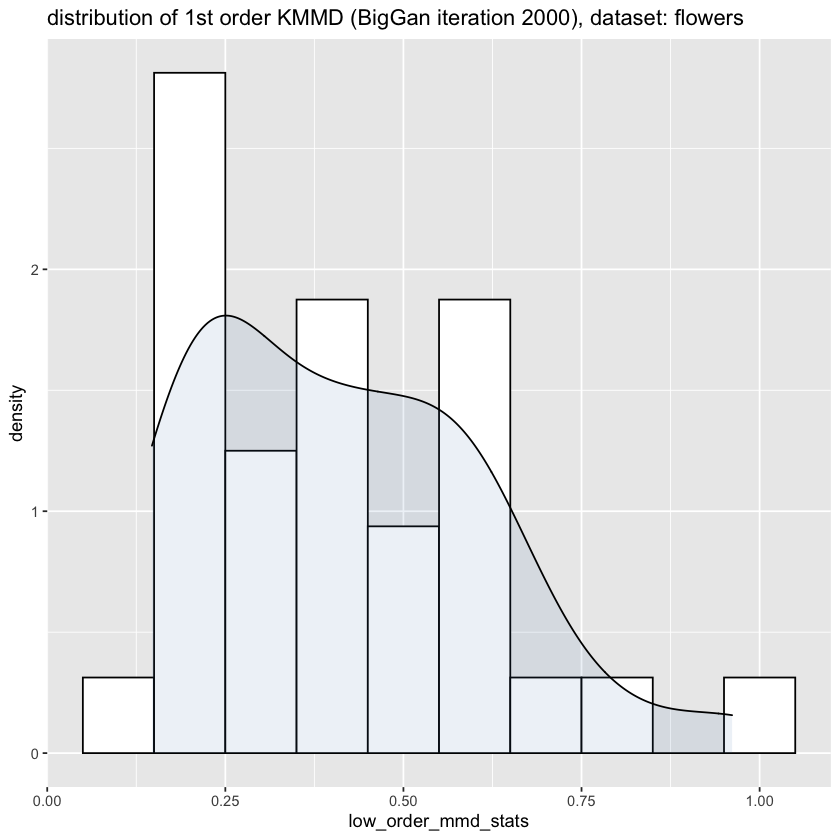

In [73]:
ggplot(df_low_order_mmd_stats, aes(x=low_order_mmd_stats)) +
    labs(title="distribution of 1st order KMMD (BigGan iteration 2000), dataset: flowers") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="steelblue")  # Overlay with transparent density plot

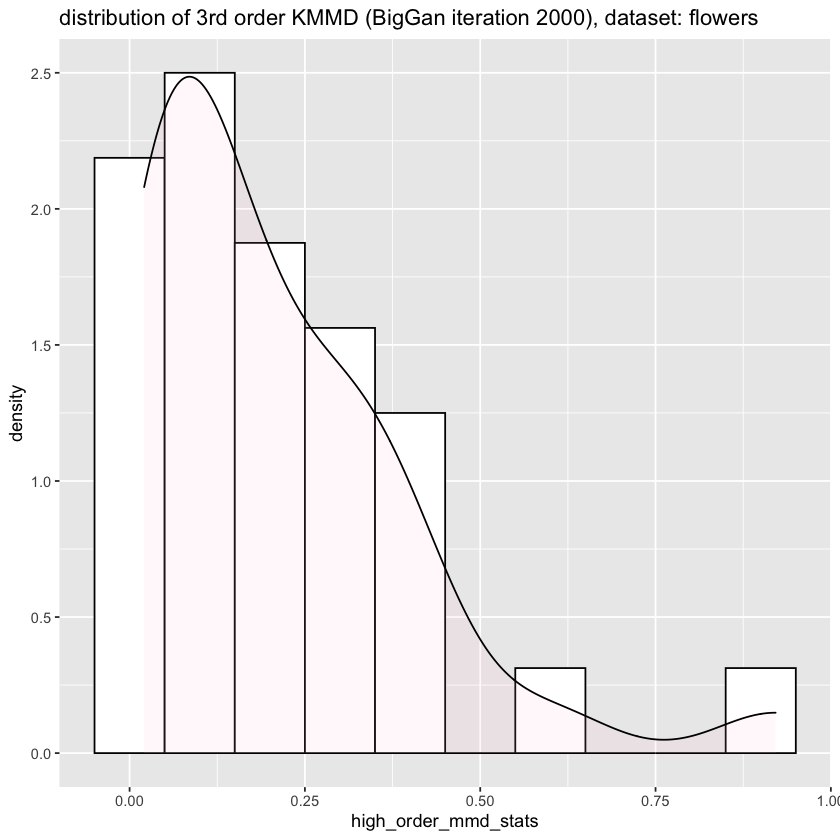

In [74]:
ggplot(df_high_order_mmd_stats, aes(x=high_order_mmd_stats)) +
    labs(title="distribution of 3rd order KMMD (BigGan iteration 2000), dataset: flowers") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="pink")  # Overlay with transparent density plot

In [75]:
summary(df_low_order_mmd_stats)

 low_order_mmd_stats
 Min.   :0.1470     
 1st Qu.:0.2361     
 Median :0.4007     
 Mean   :0.4120     
 3rd Qu.:0.5547     
 Max.   :0.9613     

In [76]:
summary(df_high_order_mmd_stats)

 high_order_mmd_stats
 Min.   :0.02075     
 1st Qu.:0.05430     
 Median :0.15750     
 Mean   :0.20625     
 3rd Qu.:0.30452     
 Max.   :0.92120     

### face

In [202]:
result_face = compute_kmmd("./biggan_face_results/input", "./biggan_face_results/iter_2000")

Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (

In [203]:
H0.reject = result_face$H0.reject
df_H0.reject = as.data.frame(H0.reject) %>% group_by(H0.reject) %>% count() %>% rename("inference_count"=n)
low_order_mmd_stats = result_face$low_order_mmd_stats
df_low_order_mmd_stats = as.data.frame(low_order_mmd_stats)
high_order_mmd_stats = result_face$high_order_mmd_stats
df_high_order_mmd_stats = as.data.frame(high_order_mmd_stats)

#### Hypothesis test result

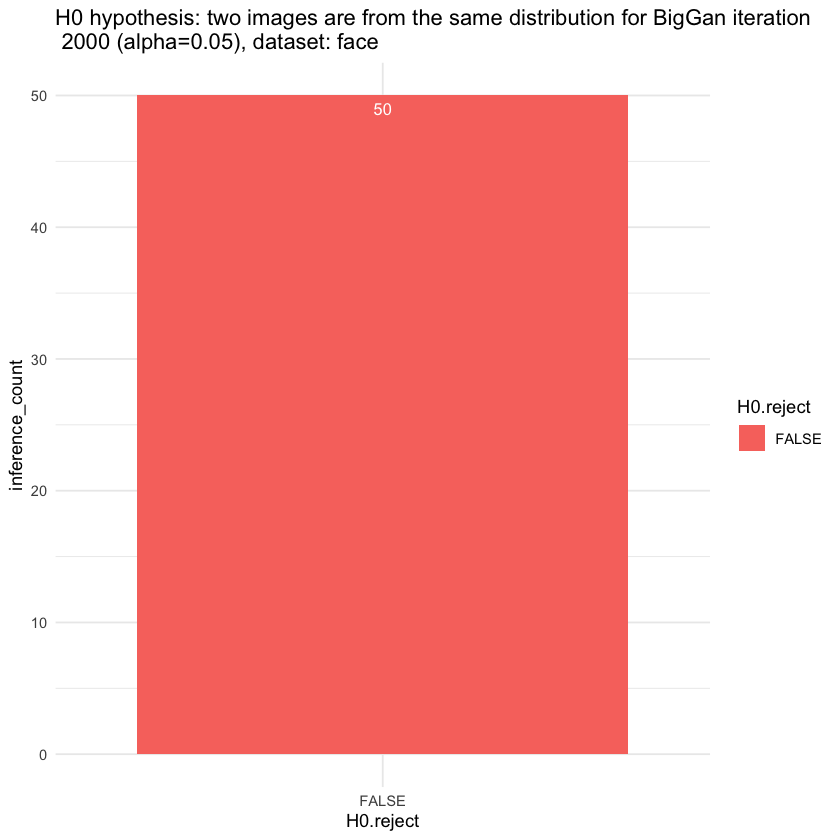

In [204]:
ggplot(data=df_H0.reject, aes(x=H0.reject, y=inference_count, fill=H0.reject)) +
  labs(title="H0 hypothesis: two images are from the same distribution for BigGan iteration\n 2000 (alpha=0.05), dataset: face") +
  geom_bar(stat="identity")+
  geom_text(aes(label=inference_count), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

#### MMD statistics

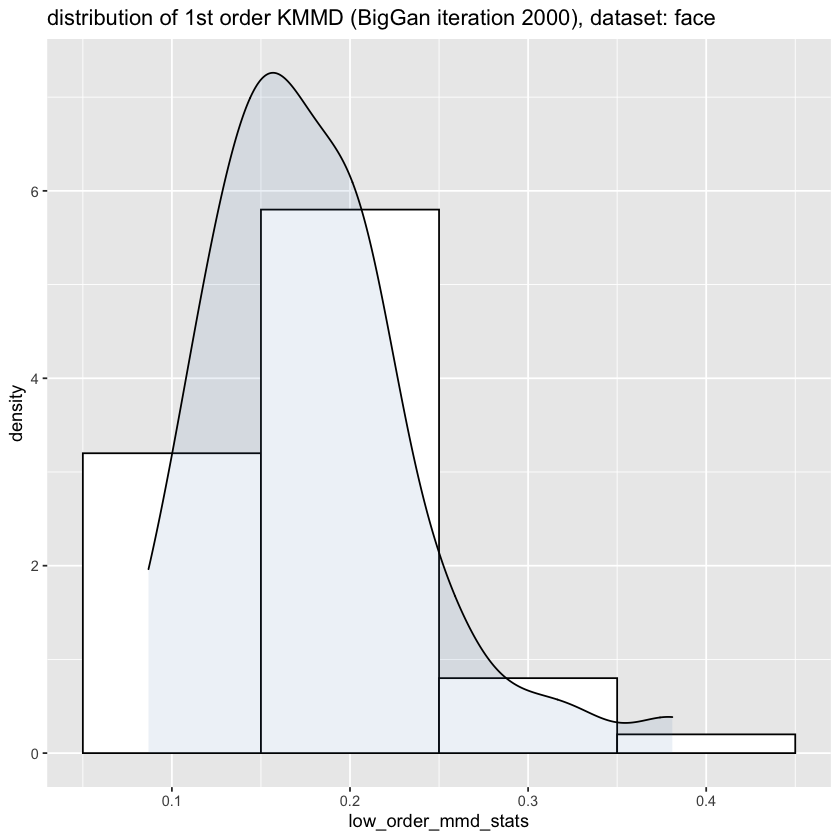

In [205]:
ggplot(df_low_order_mmd_stats, aes(x=low_order_mmd_stats)) +
    labs(title="distribution of 1st order KMMD (BigGan iteration 2000), dataset: face") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="steelblue")  # Overlay with transparent density plot

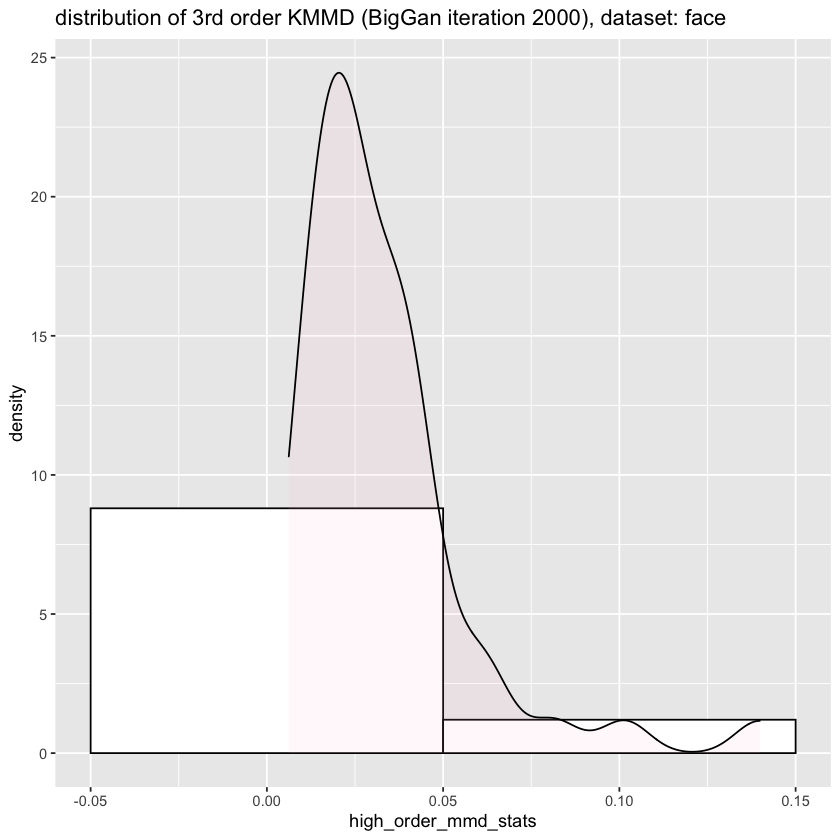

In [206]:
ggplot(df_high_order_mmd_stats, aes(x=high_order_mmd_stats)) +
    labs(title="distribution of 3rd order KMMD (BigGan iteration 2000), dataset: face") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="pink")  # Overlay with transparent density plot

In [207]:
summary(df_low_order_mmd_stats)

 low_order_mmd_stats
 Min.   :0.08686    
 1st Qu.:0.13603    
 Median :0.16570    
 Mean   :0.17887    
 3rd Qu.:0.20574    
 Max.   :0.38098    

In [208]:
summary(df_high_order_mmd_stats)

 high_order_mmd_stats
 Min.   :0.006209    
 1st Qu.:0.017121    
 Median :0.025473    
 Mean   :0.032912    
 3rd Qu.:0.039507    
 Max.   :0.139827    

### anime

In [217]:
result_anime = compute_kmmd("./biggan_anime_results/input", "./biggan_anime_results/iter_2000")

Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (

In [218]:
H0.reject = result_anime$H0.reject
df_H0.reject = as.data.frame(H0.reject) %>% group_by(H0.reject) %>% count() %>% rename("inference_count"=n)
low_order_mmd_stats = result_anime$low_order_mmd_stats
df_low_order_mmd_stats = as.data.frame(low_order_mmd_stats)
high_order_mmd_stats = result_anime$high_order_mmd_stats
df_high_order_mmd_stats = as.data.frame(high_order_mmd_stats)

#### Hypothesis test result

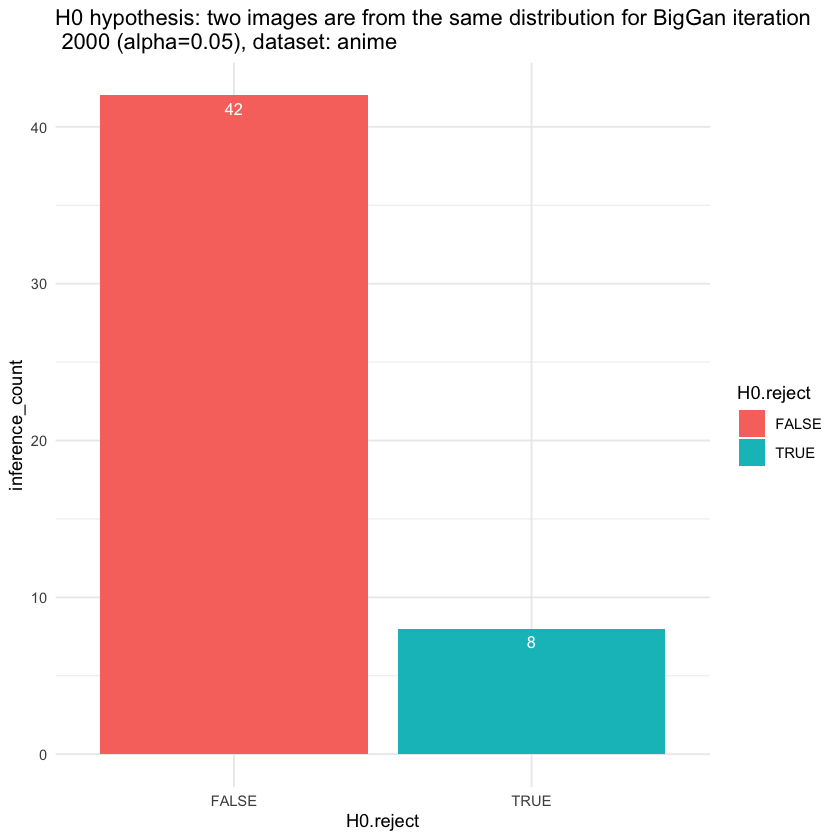

In [219]:
ggplot(data=df_H0.reject, aes(x=H0.reject, y=inference_count, fill=H0.reject)) +
  labs(title="H0 hypothesis: two images are from the same distribution for BigGan iteration\n 2000 (alpha=0.05), dataset: anime") +
  geom_bar(stat="identity")+
  geom_text(aes(label=inference_count), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

#### MMD statistics

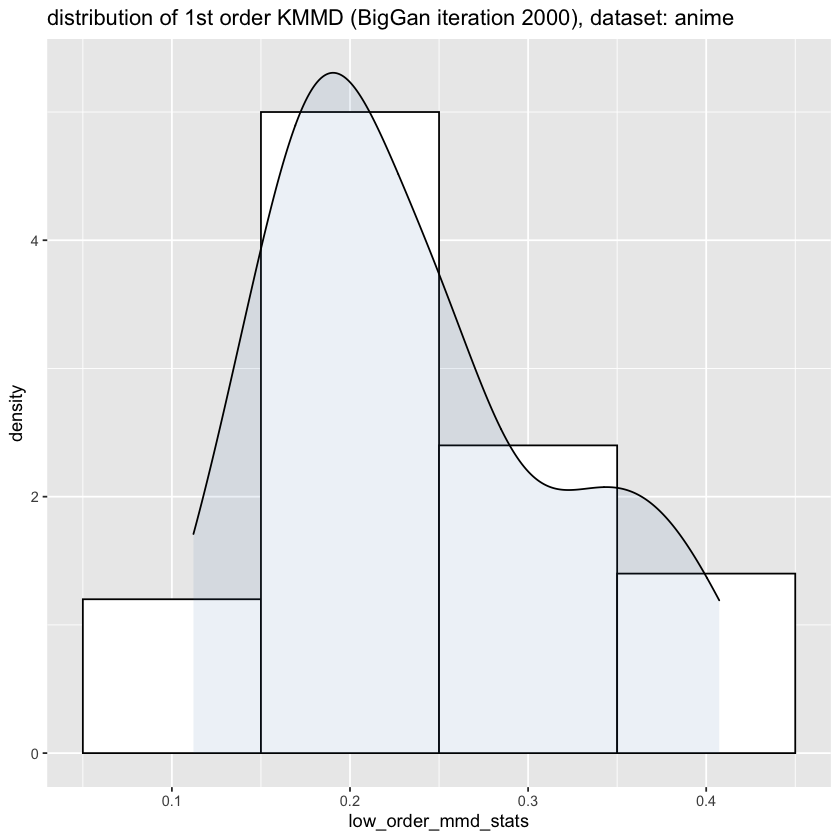

In [220]:
ggplot(df_low_order_mmd_stats, aes(x=low_order_mmd_stats)) +
    labs(title="distribution of 1st order KMMD (BigGan iteration 2000), dataset: anime") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="steelblue")  # Overlay with transparent density plot

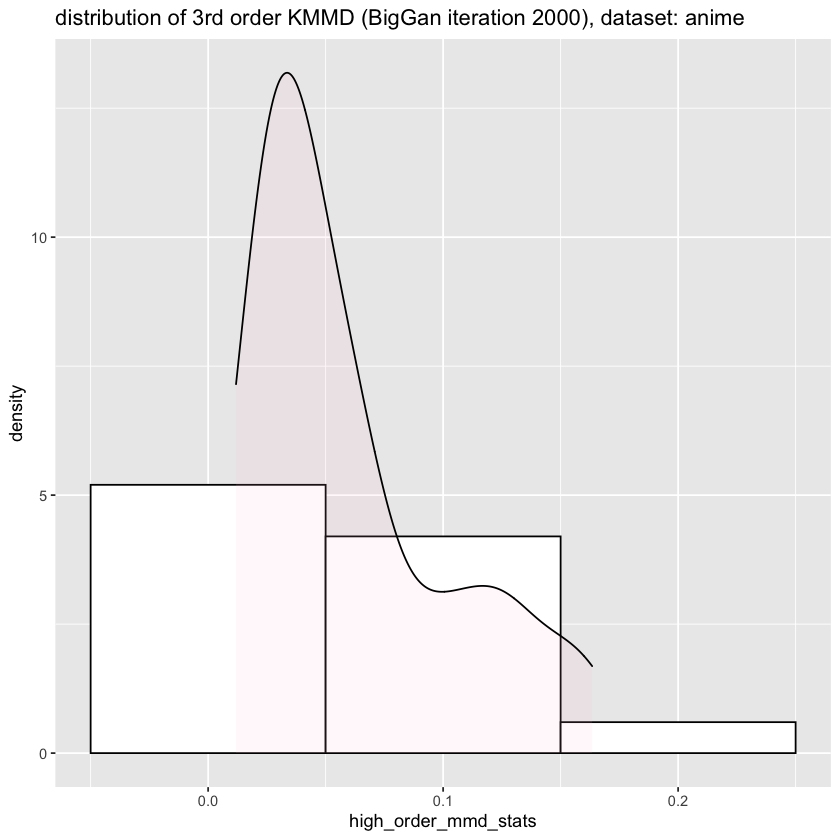

In [221]:
ggplot(df_high_order_mmd_stats, aes(x=high_order_mmd_stats)) +
    labs(title="distribution of 3rd order KMMD (BigGan iteration 2000), dataset: anime") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="pink")  # Overlay with transparent density plot

In [222]:
summary(df_low_order_mmd_stats)

 low_order_mmd_stats
 Min.   :0.1121     
 1st Qu.:0.1814     
 Median :0.2156     
 Mean   :0.2367     
 3rd Qu.:0.2823     
 Max.   :0.4073     

In [223]:
summary(df_high_order_mmd_stats)

 high_order_mmd_stats
 Min.   :0.01187     
 1st Qu.:0.03117     
 Median :0.04444     
 Mean   :0.06039     
 3rd Qu.:0.07756     
 Max.   :0.16341     

## Result of datasets for BigGan (iteration 5000)

### flowers

In [231]:
result_flowers = compute_kmmd("./biggan_flower_results/input", "./biggan_flower_results/iter_5000")

Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (

In [232]:
H0.reject = result_flowers$H0.reject
df_H0.reject = as.data.frame(H0.reject) %>% group_by(H0.reject) %>% count() %>% rename("inference_count"=n)
low_order_mmd_stats = result_flowers$low_order_mmd_stats
df_low_order_mmd_stats = as.data.frame(low_order_mmd_stats)
high_order_mmd_stats = result_flowers$high_order_mmd_stats
df_high_order_mmd_stats = as.data.frame(high_order_mmd_stats)

#### Hypothesis test result

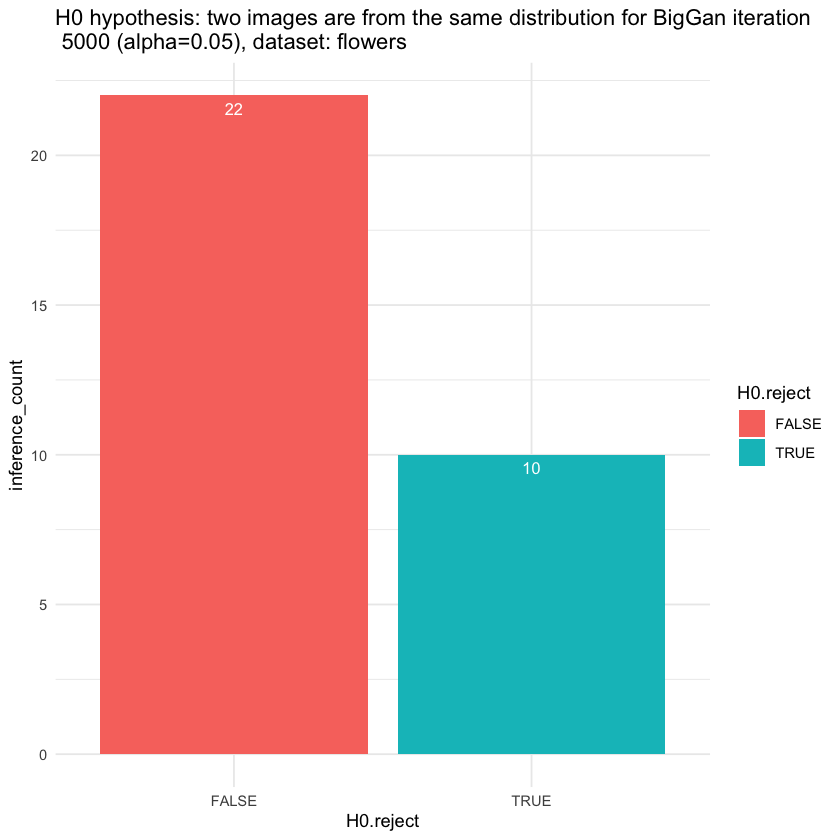

In [233]:
ggplot(data=df_H0.reject, aes(x=H0.reject, y=inference_count, fill=H0.reject)) +
  labs(title="H0 hypothesis: two images are from the same distribution for BigGan iteration\n 5000 (alpha=0.05), dataset: flowers") +
  geom_bar(stat="identity")+
  geom_text(aes(label=inference_count), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

#### MMD statistics

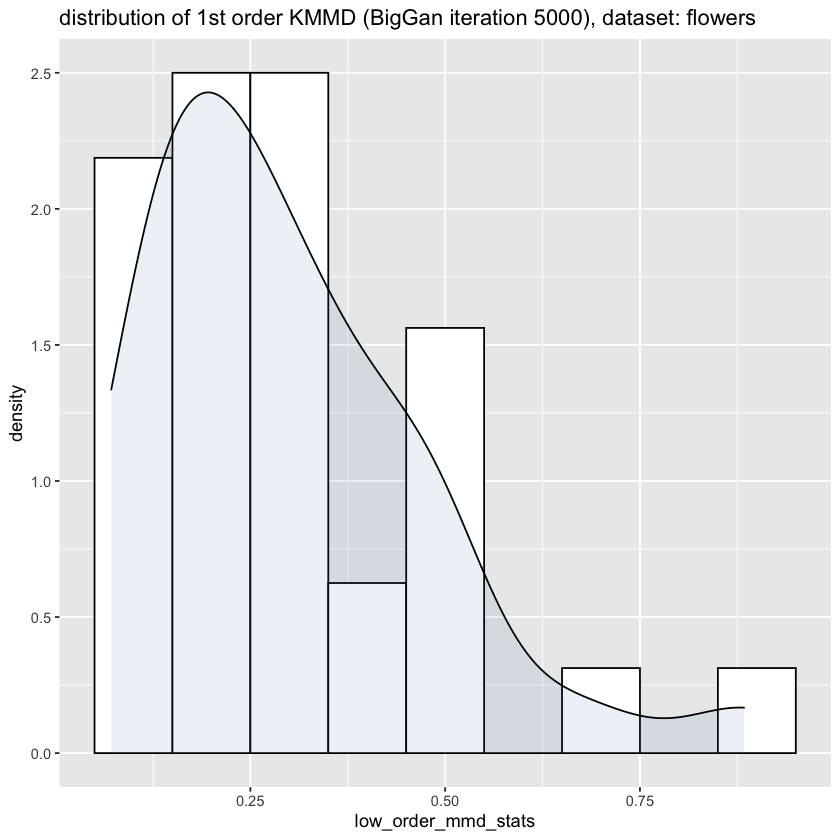

In [234]:
ggplot(df_low_order_mmd_stats, aes(x=low_order_mmd_stats)) +
    labs(title="distribution of 1st order KMMD (BigGan iteration 5000), dataset: flowers") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="steelblue")  # Overlay with transparent density plot

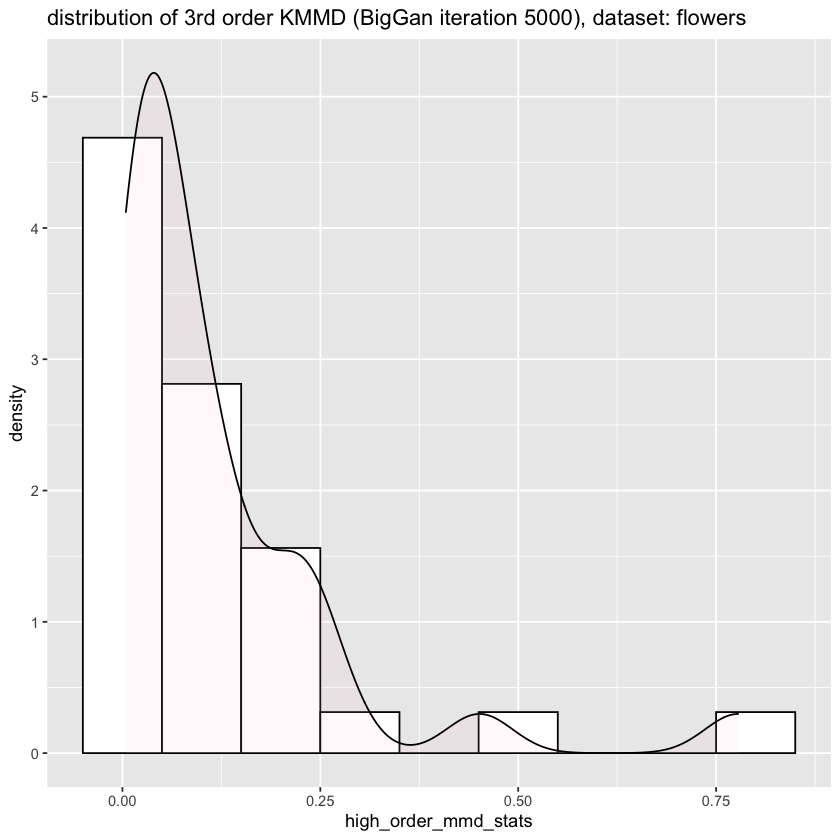

In [235]:
ggplot(df_high_order_mmd_stats, aes(x=high_order_mmd_stats)) +
    labs(title="distribution of 3rd order KMMD (BigGan iteration 5000), dataset: flowers") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="pink")  # Overlay with transparent density plot

In [238]:
summary(df_low_order_mmd_stats)

 low_order_mmd_stats
 Min.   :0.07145    
 1st Qu.:0.16366    
 Median :0.25251    
 Mean   :0.29985    
 3rd Qu.:0.39105    
 Max.   :0.88358    

In [239]:
summary(df_high_order_mmd_stats)

 high_order_mmd_stats
 Min.   :0.004349    
 1st Qu.:0.025602    
 Median :0.061978    
 Mean   :0.119626    
 3rd Qu.:0.150000    
 Max.   :0.777871    

### face

In [240]:
result_face = compute_kmmd("./biggan_face_results/input", "./biggan_face_results/iter_5000")

Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (

In [241]:
H0.reject = result_face$H0.reject
df_H0.reject = as.data.frame(H0.reject) %>% group_by(H0.reject) %>% count() %>% rename("inference_count"=n)
low_order_mmd_stats = result_face$low_order_mmd_stats
df_low_order_mmd_stats = as.data.frame(low_order_mmd_stats)
high_order_mmd_stats = result_face$high_order_mmd_stats
df_high_order_mmd_stats = as.data.frame(high_order_mmd_stats)

#### Hypothesis test result

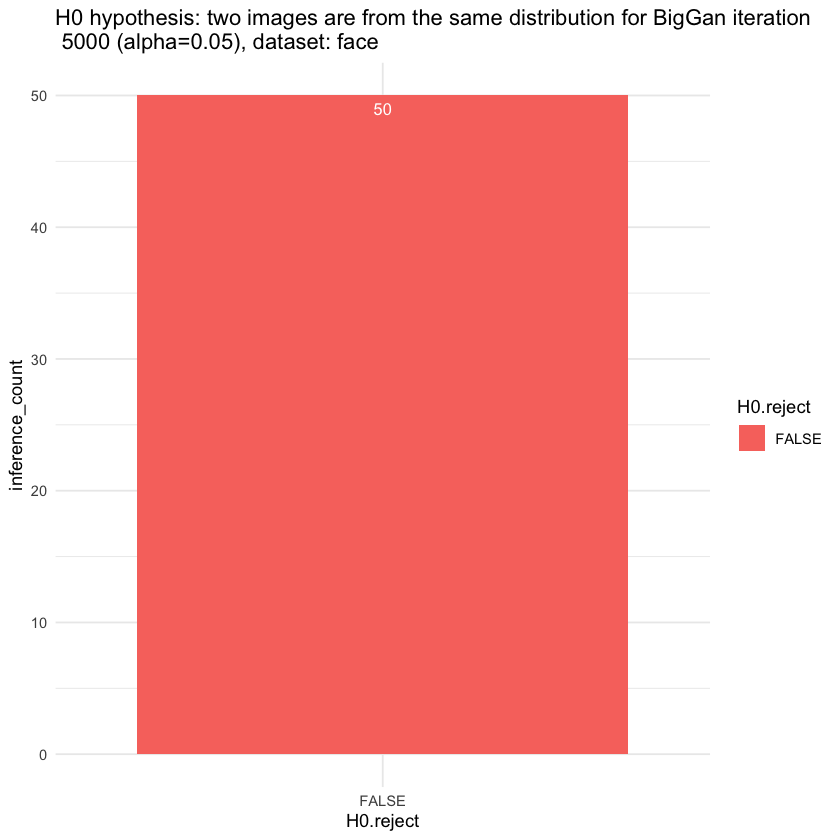

In [247]:
ggplot(data=df_H0.reject, aes(x=H0.reject, y=inference_count, fill=H0.reject)) +
  labs(title="H0 hypothesis: two images are from the same distribution for BigGan iteration\n 5000 (alpha=0.05), dataset: face") +
  geom_bar(stat="identity")+
  geom_text(aes(label=inference_count), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

#### MMD statistics

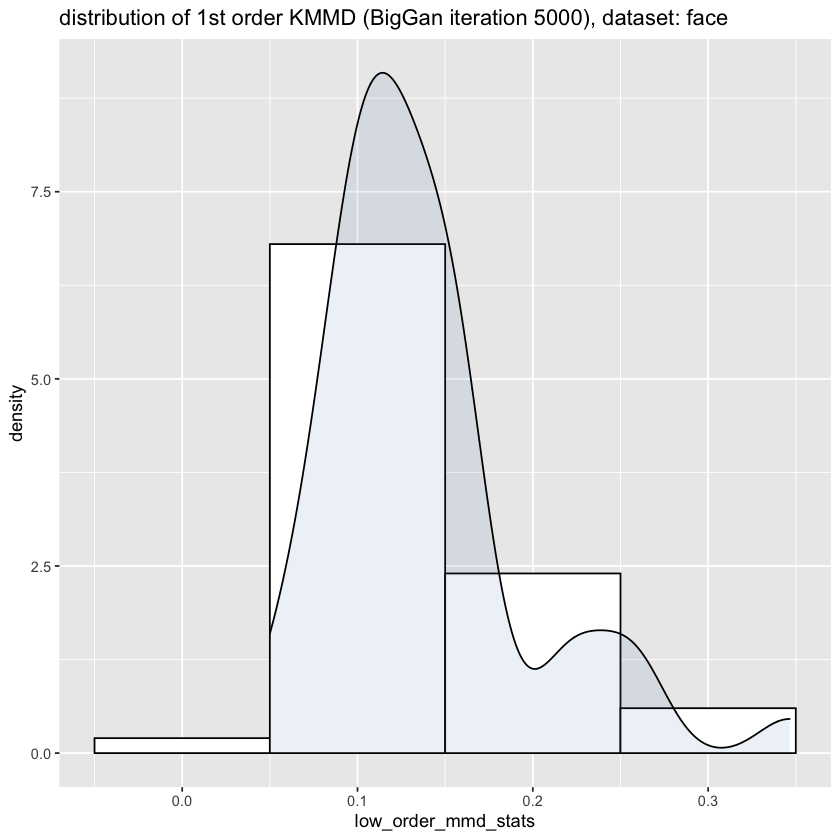

In [248]:
ggplot(df_low_order_mmd_stats, aes(x=low_order_mmd_stats)) +
    labs(title="distribution of 1st order KMMD (BigGan iteration 5000), dataset: face") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="steelblue")  # Overlay with transparent density plot

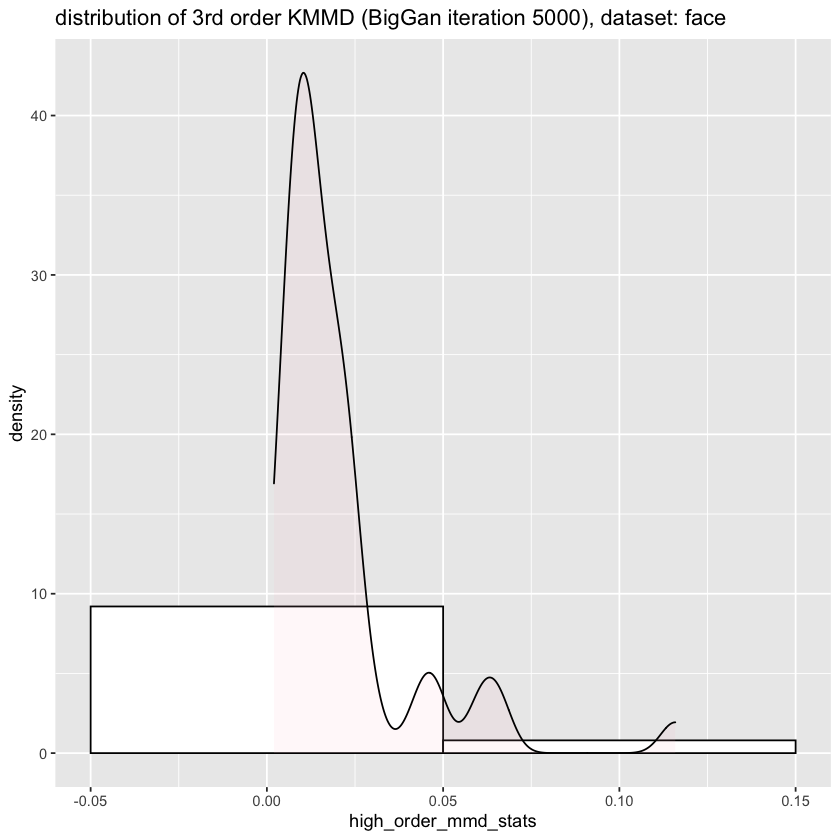

In [249]:
ggplot(df_high_order_mmd_stats, aes(x=high_order_mmd_stats)) +
    labs(title="distribution of 3rd order KMMD (BigGan iteration 5000), dataset: face") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="pink")  # Overlay with transparent density plot

In [250]:
summary(df_low_order_mmd_stats)

 low_order_mmd_stats
 Min.   :0.04999    
 1st Qu.:0.09949    
 Median :0.12403    
 Mean   :0.13767    
 3rd Qu.:0.15642    
 Max.   :0.34648    

In [251]:
summary(df_high_order_mmd_stats)

 high_order_mmd_stats
 Min.   :0.002009    
 1st Qu.:0.008974    
 Median :0.013758    
 Mean   :0.020511    
 3rd Qu.:0.022401    
 Max.   :0.115854    

### anime

In [266]:
result_anime = compute_kmmd("./biggan_face_results/input", "./biggan_anime_results/iter_5000")

Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
Using automatic sigma estimation (

In [267]:
H0.reject = result_anime$H0.reject
df_H0.reject = as.data.frame(H0.reject) %>% group_by(H0.reject) %>% count() %>% rename("inference_count"=n)
low_order_mmd_stats = result_anime$low_order_mmd_stats
df_low_order_mmd_stats = as.data.frame(low_order_mmd_stats)
high_order_mmd_stats = result_anime$high_order_mmd_stats
df_high_order_mmd_stats = as.data.frame(high_order_mmd_stats)

#### Hypothesis test result

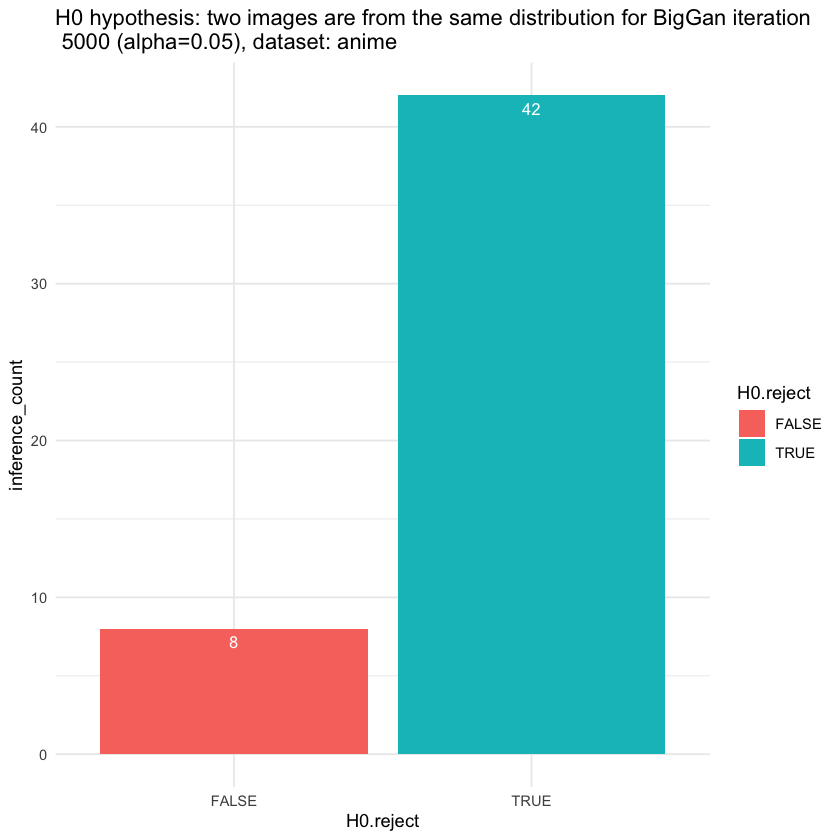

In [268]:
ggplot(data=df_H0.reject, aes(x=H0.reject, y=inference_count, fill=H0.reject)) +
  labs(title="H0 hypothesis: two images are from the same distribution for BigGan iteration\n 5000 (alpha=0.05), dataset: anime") +
  geom_bar(stat="identity")+
  geom_text(aes(label=inference_count), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

#### MMD statistics

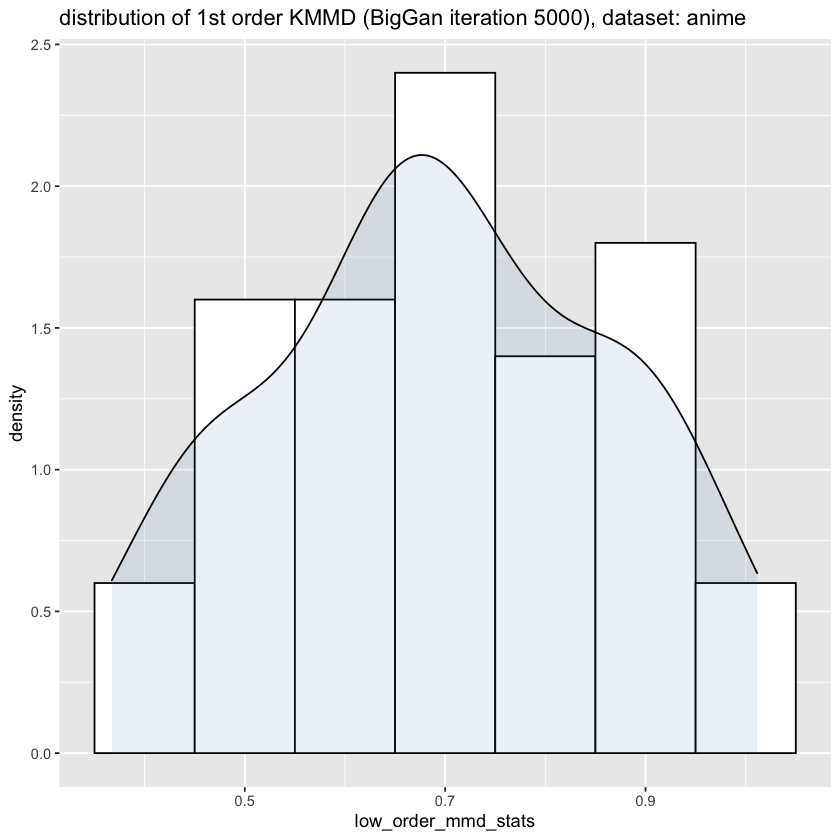

In [269]:
ggplot(df_low_order_mmd_stats, aes(x=low_order_mmd_stats)) +
    labs(title="distribution of 1st order KMMD (BigGan iteration 5000), dataset: anime") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="steelblue")  # Overlay with transparent density plot

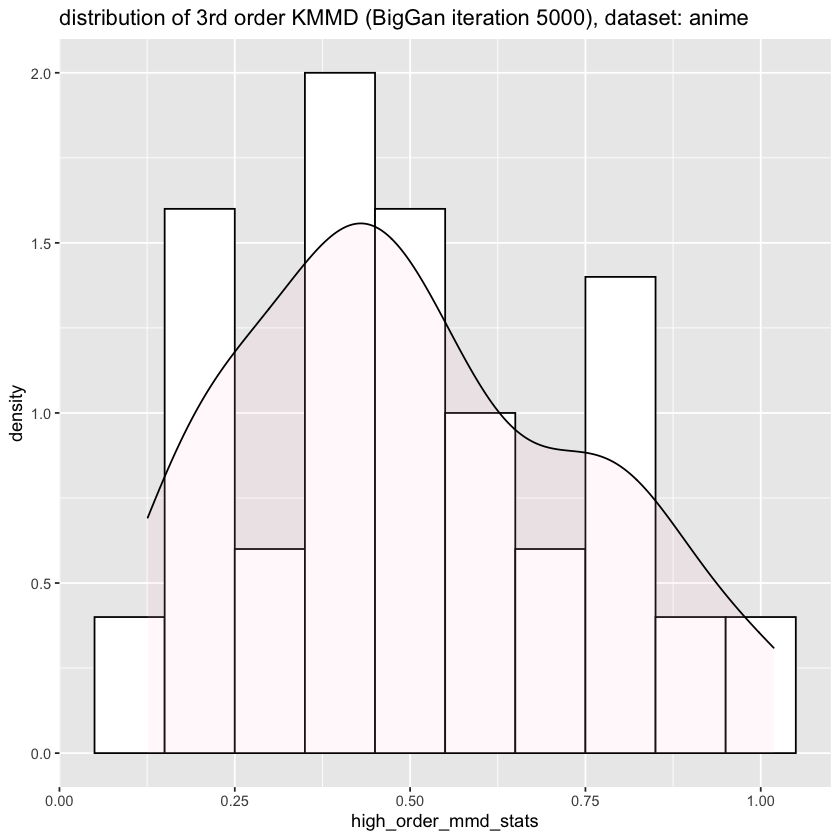

In [270]:
ggplot(df_high_order_mmd_stats, aes(x=high_order_mmd_stats)) +
    labs(title="distribution of 3rd order KMMD (BigGan iteration 5000), dataset: anime") +
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=.1,
                   colour="black", fill="white") +
    geom_density(alpha=.1, fill="pink")  # Overlay with transparent density plot

In [271]:
summary(df_low_order_mmd_stats)

 low_order_mmd_stats
 Min.   :0.3673     
 1st Qu.:0.5990     
 Median :0.6815     
 Mean   :0.6939     
 3rd Qu.:0.8323     
 Max.   :1.0115     

In [272]:
summary(df_high_order_mmd_stats)

 high_order_mmd_stats
 Min.   :0.1258      
 1st Qu.:0.3501      
 Median :0.4570      
 Mean   :0.5035      
 3rd Qu.:0.6853      
 Max.   :1.0185      